In [120]:
import pandas as pd 
import datetime as dt
import numpy as np
import matplotlib.pyplot as  plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

RANDOM_SEED = 42
pd.set_option('display.max_columns', None)

In [3]:
fraud_data=pd.read_csv("Fraud_data.csv")
In_pat=pd.read_csv("Inpatientdata.csv")
Out_pat=pd.read_csv("Outpatientdata.csv")
Beneficiary=pd.read_csv("Beneficiarydata.csv")

In [4]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5410 entries, 0 to 5409
Data columns (total 2 columns):
Provider          5410 non-null object
PotentialFraud    5410 non-null object
dtypes: object(2)
memory usage: 84.6+ KB


In [5]:
In_pat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40474 entries, 0 to 40473
Data columns (total 30 columns):
BeneID                    40474 non-null object
ClaimID                   40474 non-null object
ClaimStartDt              40474 non-null object
ClaimEndDt                40474 non-null object
Provider                  40474 non-null object
InscClaimAmtReimbursed    40474 non-null int64
AttendingPhysician        40362 non-null object
OperatingPhysician        23830 non-null object
OtherPhysician            4690 non-null object
AdmissionDt               40474 non-null object
ClmAdmitDiagnosisCode     40474 non-null object
DeductibleAmtPaid         39575 non-null float64
DischargeDt               40474 non-null object
DiagnosisGroupCode        40474 non-null object
ClmDiagnosisCode_1        40474 non-null object
ClmDiagnosisCode_2        40248 non-null object
ClmDiagnosisCode_3        39798 non-null object
ClmDiagnosisCode_4        38940 non-null object
ClmDiagnosisCode_5        37

In [123]:
Out_pat.info(max_cols=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517737 entries, 0 to 517736
Data columns (total 27 columns):
BeneID                    517737 non-null object
ClaimID                   517737 non-null object
ClaimStartDt              517737 non-null object
ClaimEndDt                517737 non-null object
Provider                  517737 non-null object
InscClaimAmtReimbursed    517737 non-null int64
AttendingPhysician        516341 non-null object
OperatingPhysician        90617 non-null object
OtherPhysician            195046 non-null object
ClmDiagnosisCode_1        507284 non-null object
ClmDiagnosisCode_2        322357 non-null object
ClmDiagnosisCode_3        203257 non-null object
ClmDiagnosisCode_4        125596 non-null object
ClmDiagnosisCode_5        74344 non-null object
ClmDiagnosisCode_6        48756 non-null object
ClmDiagnosisCode_7        32961 non-null object
ClmDiagnosisCode_8        22912 non-null object
ClmDiagnosisCode_9        14838 non-null object
ClmDiagnosisCo

In [7]:
Beneficiary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138556 entries, 0 to 138555
Data columns (total 25 columns):
BeneID                             138556 non-null object
DOB                                138556 non-null object
DOD                                1421 non-null object
Gender                             138556 non-null int64
Race                               138556 non-null int64
RenalDiseaseIndicator              138556 non-null object
State                              138556 non-null int64
County                             138556 non-null int64
NoOfMonths_PartACov                138556 non-null int64
NoOfMonths_PartBCov                138556 non-null int64
ChronicCond_Alzheimer              138556 non-null int64
ChronicCond_Heartfailure           138556 non-null int64
ChronicCond_KidneyDisease          138556 non-null int64
ChronicCond_Cancer                 138556 non-null int64
ChronicCond_ObstrPulmonary         138556 non-null int64
ChronicCond_Depression          

In [16]:
Beneficiary.isna().sum()

BeneID                                  0
DOB                                     0
DOD                                137135
Gender                                  0
Race                                    0
RenalDiseaseIndicator                   0
State                                   0
County                                  0
NoOfMonths_PartACov                     0
NoOfMonths_PartBCov                     0
ChronicCond_Alzheimer                   0
ChronicCond_Heartfailure                0
ChronicCond_KidneyDisease               0
ChronicCond_Cancer                      0
ChronicCond_ObstrPulmonary              0
ChronicCond_Depression                  0
ChronicCond_Diabetes                    0
ChronicCond_IschemicHeart               0
ChronicCond_Osteoporasis                0
ChronicCond_rheumatoidarthritis         0
ChronicCond_stroke                      0
IPAnnualReimbursementAmt                0
IPAnnualDeductibleAmt                   0
OPAnnualReimbursementAmt          

In [18]:
##Replacing 2 with 0 for chronic conditions, and renal to 0 and 1 
Beneficiary = Beneficiary.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0)

Beneficiary = Beneficiary.replace({'RenalDiseaseIndicator': 'Y'}, 1)

In [19]:
Beneficiary.head(10)

BeneID         DOB         DOD  Gender  Race RenalDiseaseIndicator  \
0  BENE11001  1943-01-01         NaN       1     1                     0   
1  BENE11002  1936-09-01         NaN       2     1                     0   
2  BENE11003  1936-08-01         NaN       1     1                     0   
3  BENE11004  1922-07-01         NaN       1     1                     0   
4  BENE11005  1935-09-01         NaN       1     1                     0   
5  BENE11006  1976-09-01         NaN       2     1                     0   
6  BENE11007  1940-09-01  2009-12-01       1     2                     0   
7  BENE11008  1934-02-01         NaN       2     1                     0   
8  BENE11009  1929-06-01         NaN       1     1                     1   
9  BENE11010  1936-07-01         NaN       2     1                     0   

   State  County  NoOfMonths_PartACov  NoOfMonths_PartBCov  ...  \
0     39     230                   12                   12  ...   
1     39     280                   12                   12  ...   
2     52     590                   12                   12  ...   
3     39     270                   12                   12  ...   
4     24     680                   12                   12  ...   
5     23     810                   12                   12  ...   
6     45     610                   12                   12  ...   
7     15     140                   12                   12  ...   
8     44     230                   12                   12  ...   
9     41      30                   12                   12  ...   

   ChronicCond_Depression  ChronicCond_Diabetes  ChronicCond_IschemicHeart  \
0                       1                     1                          1   
1                       0                     0                          0   
2                       0                     0                          1   
3                       0                     1                          1   
4                       0                     1                          0   
5                       0                     0                          0   
6                       0                     1                          0   
7                       0                     1                          0   
8                       0                     1                          0   
9                       0                     1                          1   

   ChronicCond_Osteoporasis  ChronicCond_rheumatoidarthritis  \
0                         0                                1   
1                         0                                0   
2                         0                                0   
3                         1                                1   
4                         0                                0   
5                         0                                0   
6                         1                                1   
7                         0                                0   
8                         0                                0   
9                         1                                0   

   ChronicCond_stroke  IPAnnualReimbursementAmt  IPAnnualDeductibleAmt  \
0                   1                     36000                   3204   
1                   0                         0                      0   
2                   0                         0                      0   
3                   0                         0                      0   
4                   0                         0                      0   
5                   0                         0                      0   
6                   0                         0                      0   
7                   0                         0                      0   
8                   0                         0                      0   
9                   0                         0                      0   

   OPAnnualReimbursementAmt  OPAnnualDeductibleAmt  

In [20]:
##Add Age of Person based on his/her DOD(Date of death ) and DOB (Date of Birth)
Beneficiary['DOB'] = pd.to_datetime(Beneficiary['DOB'] , format = '%Y-%m-%d')
Beneficiary['DOD'] = pd.to_datetime(Beneficiary['DOD'],format = '%Y-%m-%d',errors='ignore')
Beneficiary['Age'] = round(((Beneficiary['DOD'] - Beneficiary['DOB']).dt.days)/365)

In [21]:
Beneficiary.head(10)

BeneID        DOB        DOD  Gender  Race RenalDiseaseIndicator  State  \
0  BENE11001 1943-01-01        NaT       1     1                     0     39   
1  BENE11002 1936-09-01        NaT       2     1                     0     39   
2  BENE11003 1936-08-01        NaT       1     1                     0     52   
3  BENE11004 1922-07-01        NaT       1     1                     0     39   
4  BENE11005 1935-09-01        NaT       1     1                     0     24   
5  BENE11006 1976-09-01        NaT       2     1                     0     23   
6  BENE11007 1940-09-01 2009-12-01       1     2                     0     45   
7  BENE11008 1934-02-01        NaT       2     1                     0     15   
8  BENE11009 1929-06-01        NaT       1     1                     1     44   
9  BENE11010 1936-07-01        NaT       2     1                     0     41   

   County  NoOfMonths_PartACov  NoOfMonths_PartBCov  ...  \
0     230                   12                   12  ...   
1     280                   12                   12  ...   
2     590                   12                   12  ...   
3     270                   12                   12  ...   
4     680                   12                   12  ...   
5     810                   12                   12  ...   
6     610                   12                   12  ...   
7     140                   12                   12  ...   
8     230                   12                   12  ...   
9      30                   12                   12  ...   

   ChronicCond_Diabetes  ChronicCond_IschemicHeart  ChronicCond_Osteoporasis  \
0                     1                          1                         0   
1                     0                          0                         0   
2                     0                          1                         0   
3                     1                          1                         1   
4                     1                          0                         0   
5                     0                          0                         0   
6                     1                          0                         1   
7                     1                          0                         0   
8                     1                          0                         0   
9                     1                          1                         1   

   ChronicCond_rheumatoidarthritis  ChronicCond_stroke  \
0                                1                   1   
1                                0                   0   
2                                0                   0   
3                                1                   0   
4                                0                   0   
5                                0                   0   
6                                1                   0   
7                                0                   0   
8                                0                   0   
9                                0                   0   

   IPAnnualReimbursementAmt  IPAnnualDeductibleAmt  OPAnnualReimbursementAmt  \
0                     36000                   3204                        60   
1                         0                      0                        30   
2                         0                      0                        90   
3                         0                      0                      1810   
4                         0                      0                      1790   
5                         0                      0                       500   
6                         0                      0                      1490   
7                         0                      0                        30   
8                         0                      0                       100   
9                         0                      0                      1170   

   OPAnnualDeductibleAmt   Age  
0                  

In [22]:
##Calculate age based on 2009-12-01
Beneficiary.Age.fillna(round(((pd.to_datetime('2009-12-01' , format = '%Y-%m-%d') - Beneficiary['DOB']).dt.days)/365),inplace=True)

In [23]:
Beneficiary.head(10)

BeneID        DOB        DOD  Gender  Race RenalDiseaseIndicator  State  \
0  BENE11001 1943-01-01        NaT       1     1                     0     39   
1  BENE11002 1936-09-01        NaT       2     1                     0     39   
2  BENE11003 1936-08-01        NaT       1     1                     0     52   
3  BENE11004 1922-07-01        NaT       1     1                     0     39   
4  BENE11005 1935-09-01        NaT       1     1                     0     24   
5  BENE11006 1976-09-01        NaT       2     1                     0     23   
6  BENE11007 1940-09-01 2009-12-01       1     2                     0     45   
7  BENE11008 1934-02-01        NaT       2     1                     0     15   
8  BENE11009 1929-06-01        NaT       1     1                     1     44   
9  BENE11010 1936-07-01        NaT       2     1                     0     41   

   County  NoOfMonths_PartACov  NoOfMonths_PartBCov  ...  \
0     230                   12                   12  ...   
1     280                   12                   12  ...   
2     590                   12                   12  ...   
3     270                   12                   12  ...   
4     680                   12                   12  ...   
5     810                   12                   12  ...   
6     610                   12                   12  ...   
7     140                   12                   12  ...   
8     230                   12                   12  ...   
9      30                   12                   12  ...   

   ChronicCond_Diabetes  ChronicCond_IschemicHeart  ChronicCond_Osteoporasis  \
0                     1                          1                         0   
1                     0                          0                         0   
2                     0                          1                         0   
3                     1                          1                         1   
4                     1                          0                         0   
5                     0                          0                         0   
6                     1                          0                         1   
7                     1                          0                         0   
8                     1                          0                         0   
9                     1                          1                         1   

   ChronicCond_rheumatoidarthritis  ChronicCond_stroke  \
0                                1                   1   
1                                0                   0   
2                                0                   0   
3                                1                   0   
4                                0                   0   
5                                0                   0   
6                                1                   0   
7                                0                   0   
8                                0                   0   
9                                0                   0   

   IPAnnualReimbursementAmt  IPAnnualDeductibleAmt  OPAnnualReimbursementAmt  \
0                     36000                   3204                        60   
1                         0                      0                        30   
2                         0                      0                        90   
3                         0                      0                      1810   
4                         0                      0                      1790   
5                         0                      0                       500   
6                         0                      0                      1490   
7                         0                      0                        30   
8                         0                      0                       100   
9                         0                      0                      1170   

   OPAnnualDeductibleAmt   Age  
0                  

In [37]:
##wheather dead
Beneficiary.loc[Beneficiary.DOD.isna(),'WhetherDead']=0
Beneficiary.loc[Beneficiary.DOD.notna(),'WhetherDead']=1

In [38]:
Beneficiary.head(10)

BeneID        DOB        DOD  Gender  Race RenalDiseaseIndicator  State  \
0  BENE11001 1943-01-01        NaT       1     1                     0     39   
1  BENE11002 1936-09-01        NaT       2     1                     0     39   
2  BENE11003 1936-08-01        NaT       1     1                     0     52   
3  BENE11004 1922-07-01        NaT       1     1                     0     39   
4  BENE11005 1935-09-01        NaT       1     1                     0     24   
5  BENE11006 1976-09-01        NaT       2     1                     0     23   
6  BENE11007 1940-09-01 2009-12-01       1     2                     0     45   
7  BENE11008 1934-02-01        NaT       2     1                     0     15   
8  BENE11009 1929-06-01        NaT       1     1                     1     44   
9  BENE11010 1936-07-01        NaT       2     1                     0     41   

   County  NoOfMonths_PartACov  NoOfMonths_PartBCov  ...  \
0     230                   12                   12  ...   
1     280                   12                   12  ...   
2     590                   12                   12  ...   
3     270                   12                   12  ...   
4     680                   12                   12  ...   
5     810                   12                   12  ...   
6     610                   12                   12  ...   
7     140                   12                   12  ...   
8     230                   12                   12  ...   
9      30                   12                   12  ...   

   ChronicCond_IschemicHeart  ChronicCond_Osteoporasis  \
0                          1                         0   
1                          0                         0   
2                          1                         0   
3                          1                         1   
4                          0                         0   
5                          0                         0   
6                          0                         1   
7                          0                         0   
8                          0                         0   
9                          1                         1   

   ChronicCond_rheumatoidarthritis  ChronicCond_stroke  \
0                                1                   1   
1                                0                   0   
2                                0                   0   
3                                1                   0   
4                                0                   0   
5                                0                   0   
6                                1                   0   
7                                0                   0   
8                                0                   0   
9                                0                   0   

   IPAnnualReimbursementAmt  IPAnnualDeductibleAmt  OPAnnualReimbursementAmt  \
0                     36000                   3204                        60   
1                         0                      0                        30   
2                         0                      0                        90   
3                         0                      0                      1810   
4                         0                      0                      1790   
5                         0                      0                       500   
6                         0                      0                      1490   
7                         0                      0                        30   
8                         0                      0                       100   
9                         0                      0                      1170   

   OPAnnualDeductibleAmt   Age  WhetherDead  
0                     70  67.0          0.0  
1                     50  73.0          0.0  
2                     40  73.0          0.0  
3                    760  87.0          0.0  
4                   1200  74.0          0.0  
5                 

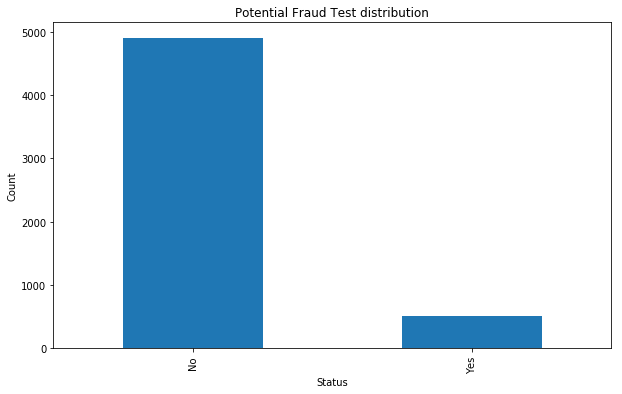

In [11]:
plt.title("Potential Fraud Test distribution")
fraud_data.groupby( ["PotentialFraud"] ).Provider.count().plot(kind = "bar", figsize = (10,6))
plt.xlabel('Potential Fraud Class ')
plt.ylabel('Count')
plt.show()

In [12]:
fraud_data.groupby( ["PotentialFraud"] ).Provider.count()

PotentialFraud
No     4904
Yes     506
Name: Provider, dtype: int64

In [133]:
df=pd.concat([In_pat,Out_pat])
df=pd.merge(df,fraud_data,on="Provider",how="outer")
df=df.fillna(0)

C:\Users\CMJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [134]:
df.head(50)

AdmissionDt  AdmitForDays AttendingPhysician      BeneID  \
0   2009-04-12 00:00:00           7.0          PHY390922   BENE11001   
1   2009-01-20 00:00:00          13.0          PHY349293   BENE17521   
2   2009-10-17 00:00:00          19.0          PHY334706   BENE21718   
3   2009-10-25 00:00:00           5.0          PHY390614   BENE22934   
4   2009-01-08 00:00:00           5.0          PHY380413   BENE24402   
5   2009-06-22 00:00:00           4.0          PHY418191   BENE28966   
6   2009-03-11 00:00:00           9.0          PHY318892   BENE29251   
7   2009-02-10 00:00:00          22.0          PHY319720   BENE31905   
8   2009-05-06 00:00:00           4.0          PHY340849   BENE31905   
9   2009-12-01 00:00:00           5.0          PHY410728   BENE31905   
10  2009-12-25 00:00:00           4.0          PHY414999   BENE31905   
11  2009-01-24 00:00:00           2.0          PHY414999   BENE37685   
12  2009-12-07 00:00:00           8.0          PHY410835   BENE37685   
13  2009-01-03 00:00:00          12.0          PHY361763   BENE45976   
14  2009-06-27 00:00:00           4.0          PHY333901   BENE46443   
15  2009-04-09 00:00:00           9.0          PHY393882   BENE50078   
16  2009-09-01 00:00:00          24.0          PHY339551   BENE50535   
17  2008-12-30 00:00:00          14.0          PHY354336   BENE53240   
18  2009-04-01 00:00:00           6.0          PHY384397   BENE53240   
19  2009-01-24 00:00:00           3.0          PHY416660   BENE53373   
20  2009-11-11 00:00:00           4.0          PHY403495   BENE54325   
21  2009-12-06 00:00:00          13.0          PHY330172   BENE54995   
22  2009-09-21 00:00:00           3.0          PHY429166   BENE56010   
23  2009-05-18 00:00:00           3.0          PHY339551   BENE58359   
24  2009-05-22 00:00:00           6.0          PHY320873   BENE61024   
25  2009-06-15 00:00:00          16.0          PHY354336   BENE64486   
26  2009-10-25 00:00:00           3.0          PHY390614   BENE64906   
27  2009-06-19 00:00:00           5.0          PHY361763   BENE68644   
28  2009-02-14 00:00:00           4.0          PHY370861   BENE70733   
29  2009-10-12 00:00:00          28.0          PHY414999   BENE74730   
30  2009-10-27 00:00:00           5.0          PHY339551   BENE75561   
31  2009-11-22 00:00:00           2.0          PHY368401   BENE75561   
32  2009-09-16 00:00:00           7.0          PHY387346   BENE77314   
33  2008-12-29 00:00:00           7.0          PHY335210   BENE79742   
34  2009-08-21 00:00:00           6.0          PHY390043   BENE80270   
35  2009-08-25 00:00:00          17.0          PHY414999   BENE87712   
36  2009-02-16 00:00:00           6.0          PHY410835   BENE88798   
37  2009-05-06 00:00:00           4.0          PHY414999   BENE88996   
38  2009-12-27 00:00:00           3.0          PHY399908   BENE90846   
39  2009-06-01 00:00:00           4.0          PHY380413   BENE94212   
40  2009-08-06 00:00:00           4.0          PHY420794  BENE105393   
41  2009-09-02 00:00:00           7.0          PHY370861  BENE108491   
42  2009-04-23 00:00:00           5.0          PHY368401  BENE116116   
43  2009-02-26 00:00:00           4.0          PHY393882  BENE119291   
44  2009-07-28 00:00:00           8.0          PHY400663  BENE121277   
45  2009-03-04 00:00:00           3.0          PHY414999  BENE121804   
46  2009-08-09 00:00:00           4.0          PHY410835  BENE121804   
47  2009-01-15 00:00:00           2.0          PHY370861  BENE124092   
48  2009-01-10 00:00:00           8.0          PHY403495  BENE125702   
49  2009-04-12 00:00:00           9.0          PHY382830  BENE126334   

    ClaimEndDt   ClaimID ClaimStartDt ClmAdmitDiagnosisCode  \
0   2009-04-18  CLM46614   2009-04-12                  7866   
1   2009-02-01  CLM34721   2009-01-20                 45340   
2   2009-11-04  CLM72336   2009-10-17                 V5789   
3   2009-10-29  CLM73394   2009-10-25                 71946   
4   2009-01-12  CLM32911

In [135]:
#Label categorical data
from sklearn import preprocessing
catcols = ['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
        'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6']

le = {}
X = df[catcols].astype(str)
for i in catcols:
    print(i)
    le[i] = preprocessing.LabelEncoder()
    le[i].fit(X[i].astype(str))
    df[i] = le[i].transform(df[i].astype(str))

BeneID
ClaimID
ClaimStartDt
ClaimEndDt
Provider
AttendingPhysician
OperatingPhysician
OtherPhysician
AdmissionDt
ClmAdmitDiagnosisCode
DischargeDt
DiagnosisGroupCode
ClmDiagnosisCode_1
ClmDiagnosisCode_2
ClmDiagnosisCode_3
ClmDiagnosisCode_4
ClmDiagnosisCode_5
ClmDiagnosisCode_6
ClmDiagnosisCode_7
ClmDiagnosisCode_8
ClmDiagnosisCode_9
ClmDiagnosisCode_10
ClmProcedureCode_1
ClmProcedureCode_2
ClmProcedureCode_3
ClmProcedureCode_4
ClmProcedureCode_5
ClmProcedureCode_6


In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 32 columns):
AdmissionDt               558211 non-null int32
AdmitForDays              558211 non-null float64
AttendingPhysician        558211 non-null int32
BeneID                    558211 non-null int32
ClaimEndDt                558211 non-null int32
ClaimID                   558211 non-null int32
ClaimStartDt              558211 non-null int32
ClmAdmitDiagnosisCode     558211 non-null int32
ClmDiagnosisCode_1        558211 non-null int32
ClmDiagnosisCode_10       558211 non-null int32
ClmDiagnosisCode_2        558211 non-null int32
ClmDiagnosisCode_3        558211 non-null int32
ClmDiagnosisCode_4        558211 non-null int32
ClmDiagnosisCode_5        558211 non-null int32
ClmDiagnosisCode_6        558211 non-null int32
ClmDiagnosisCode_7        558211 non-null int32
ClmDiagnosisCode_8        558211 non-null int32
ClmDiagnosisCode_9        558211 non-null int32
ClmProcedureCode_1     

In [137]:
##prepare data
cols = ['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6']

X = df[cols]
Y = df["PotentialFraud"].apply(lambda x: True if x == "Yes" else False)

In [138]:
Y

0          True
1          True
2          True
3          True
4          True
5          True
6          True
7          True
8          True
9          True
10         True
11         True
12         True
13         True
14         True
15         True
16         True
17         True
18         True
19         True
20         True
21         True
22         True
23         True
24         True
25         True
26         True
27         True
28         True
29         True
          ...  
558181    False
558182    False
558183    False
558184    False
558185    False
558186    False
558187    False
558188    False
558189    False
558190    False
558191    False
558192    False
558193    False
558194    False
558195    False
558196    False
558197    False
558198    False
558199    False
558200    False
558201    False
558202    False
558203    False
558204    False
558205    False
558206    False
558207    False
558208    False
558209    False
558210    False
Name: PotentialFraud, Le

In [139]:
## Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=12)

In [140]:
clf = xgb.XGBClassifier(n_jobs=12, n_estimators=500)
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric=["auc","error","logloss"],
        verbose=10)

[0]	validation_0-auc:0.73338	validation_0-error:0.28047	validation_0-logloss:0.63027	validation_1-auc:0.73755	validation_1-error:0.27756	validation_1-logloss:0.62943
[10]	validation_0-auc:0.90786	validation_0-error:0.18247	validation_0-logloss:0.44902	validation_1-auc:0.91148	validation_1-error:0.18088	validation_1-logloss:0.44578
[20]	validation_0-auc:0.94919	validation_0-error:0.10873	validation_0-logloss:0.36270	validation_1-auc:0.95065	validation_1-error:0.10623	validation_1-logloss:0.35966
[30]	validation_0-auc:0.96544	validation_0-error:0.08862	validation_0-logloss:0.31717	validation_1-auc:0.96586	validation_1-error:0.08778	validation_1-logloss:0.31526
[40]	validation_0-auc:0.97817	validation_0-error:0.05991	validation_0-logloss:0.27113	validation_1-auc:0.97850	validation_1-error:0.05869	validation_1-logloss:0.26925
[50]	validation_0-auc:0.98238	validation_0-error:0.05172	validation_0-logloss:0.24767	validation_1-auc:0.98244	validation_1-error:0.05138	validation_1-logloss:0.24642

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=500, n_jobs=12, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

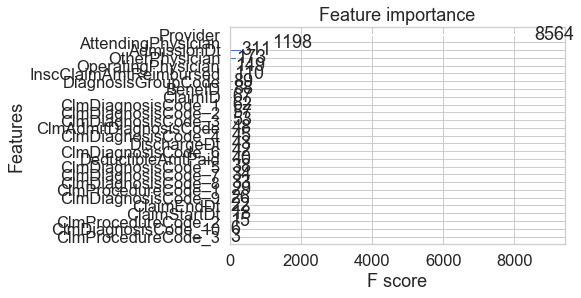

In [141]:
from xgboost import plot_importance
plot_importance(clf)

In [142]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot


In [143]:

xgb_probs=clf.predict_proba(X_test)
ns_probs = [0 for _ in range(len(y_test))]
ns_auc=roc_auc_score(y_test,ns_probs)

In [144]:
xgb_probs

array([[0.9916374 , 0.00836262],
       [0.06841767, 0.93158233],
       [0.05680716, 0.94319284],
       ...,
       [0.9940441 , 0.00595587],
       [0.9518203 , 0.04817971],
       [0.00169671, 0.9983033 ]], dtype=float32)

In [145]:
xgb_probs=xgb_probs[:,1]

In [146]:
xgb_probs

array([0.00836262, 0.93158233, 0.94319284, ..., 0.00595587, 0.04817971,
       0.9983033 ], dtype=float32)

In [147]:
xgb_auc=roc_auc_score(y_test,xgb_probs)


In [148]:
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGB: ROC AUC=%.3f' % (xgb_auc))

No Skill: ROC AUC=0.500
XGB: ROC AUC=1.000


In [149]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)


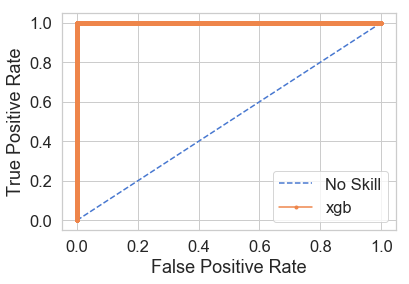

In [150]:
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(xgb_fpr, xgb_tpr, marker='.', label='xgb')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [151]:
cols = ['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6']

X = df[cols]
Y = df["PotentialFraud"].apply(lambda x: True if x == "Yes" else False)

In [152]:
Y

0          True
1          True
2          True
3          True
4          True
5          True
6          True
7          True
8          True
9          True
10         True
11         True
12         True
13         True
14         True
15         True
16         True
17         True
18         True
19         True
20         True
21         True
22         True
23         True
24         True
25         True
26         True
27         True
28         True
29         True
          ...  
558181    False
558182    False
558183    False
558184    False
558185    False
558186    False
558187    False
558188    False
558189    False
558190    False
558191    False
558192    False
558193    False
558194    False
558195    False
558196    False
558197    False
558198    False
558199    False
558200    False
558201    False
558202    False
558203    False
558204    False
558205    False
558206    False
558207    False
558208    False
558209    False
558210    False
Name: PotentialFraud, Le

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

In [155]:
clf = xgb.XGBClassifier(n_jobs=12, n_estimators=500)
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric=["auc","error","logloss"],
        verbose=10)

[0]	validation_0-auc:0.58939	validation_0-error:0.35557	validation_0-logloss:0.66843	validation_1-auc:0.58916	validation_1-error:0.35302	validation_1-logloss:0.66807
[10]	validation_0-auc:0.70369	validation_0-error:0.30918	validation_0-logloss:0.60570	validation_1-auc:0.70401	validation_1-error:0.30780	validation_1-logloss:0.60472
[20]	validation_0-auc:0.75869	validation_0-error:0.27287	validation_0-logloss:0.57687	validation_1-auc:0.75667	validation_1-error:0.27149	validation_1-logloss:0.57623
[30]	validation_0-auc:0.78086	validation_0-error:0.25937	validation_0-logloss:0.55818	validation_1-auc:0.77630	validation_1-error:0.25947	validation_1-logloss:0.55885
[40]	validation_0-auc:0.79582	validation_0-error:0.25008	validation_0-logloss:0.54688	validation_1-auc:0.78995	validation_1-error:0.25117	validation_1-logloss:0.54822
[50]	validation_0-auc:0.81505	validation_0-error:0.23605	validation_0-logloss:0.53110	validation_1-auc:0.80809	validation_1-error:0.23869	validation_1-logloss:0.53320

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=500, n_jobs=12, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

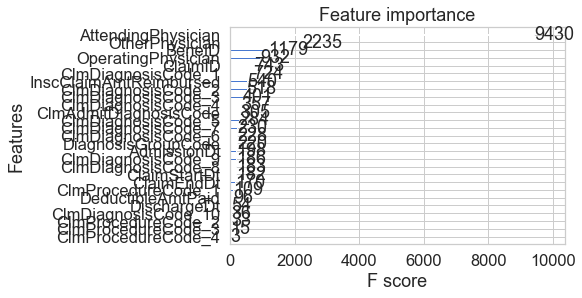

In [156]:
plot_importance(clf)

In [157]:
xgb_probs=clf.predict_proba(X_test)
ns_probs = [0 for _ in range(len(y_test))]
ns_auc=roc_auc_score(y_test,ns_probs)
xgb_probs=xgb_probs[:,1]
xgb_auc=roc_auc_score(y_test,xgb_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGB: ROC AUC=%.3f' % (xgb_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)


No Skill: ROC AUC=0.500
XGB: ROC AUC=0.922


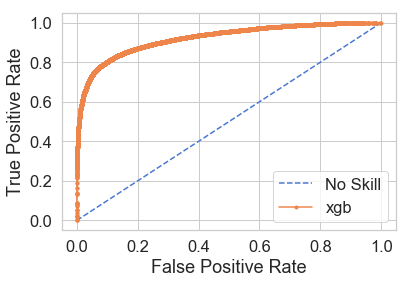

In [158]:
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(xgb_fpr, xgb_tpr, marker='.', label='xgb')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [321]:
##add beneficiary info and improve In pat abd out pat combine
In_pat['AdmissionDt'] = pd.to_datetime(In_pat['AdmissionDt'] , format = '%Y-%m-%d')
In_pat['DischargeDt'] = pd.to_datetime(In_pat['DischargeDt'] , format = '%Y-%m-%d')
In_pat['AdmitForDays'] = ((In_pat['DischargeDt'] - In_pat['AdmissionDt']).dt.days)+1

In [322]:
print(Out_pat.columns)

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
      dtype='object')


In [323]:
df1=pd.merge(Out_pat,In_pat,
                              left_on=['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
                              right_on=['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode']
                              ,how='outer')

In [324]:
df1.shape

(558211, 31)

In [325]:
df1=pd.merge(df1,Beneficiary,left_on='BeneID',right_on='BeneID',how='inner')

In [326]:
df1.shape

(558211, 57)

In [327]:
df1=pd.merge(df1,fraud_data,on="Provider",how="outer")

In [328]:
df1.isnull().sum()*100/len(df1)

BeneID                               0.000000
ClaimID                              0.000000
ClaimStartDt                         0.000000
ClaimEndDt                           0.000000
Provider                             0.000000
InscClaimAmtReimbursed               0.000000
AttendingPhysician                   0.270149
OperatingPhysician                  79.497538
OtherPhysician                      64.218548
ClmDiagnosisCode_1                   1.872589
ClmDiagnosisCode_2                  35.041588
ClmDiagnosisCode_3                  56.458221
ClmDiagnosisCode_4                  70.524407
ClmDiagnosisCode_5                  79.949517
ClmDiagnosisCode_6                  84.881702
ClmDiagnosisCode_7                  88.144805
ClmDiagnosisCode_8                  90.425843
ClmDiagnosisCode_9                  92.509105
ClmDiagnosisCode_10                 99.102490
ClmProcedureCode_1                  95.824160
ClmProcedureCode_2                  99.016501
ClmProcedureCode_3                

Text(0, 0.5, 'Number of PotentialFraud per Class ')

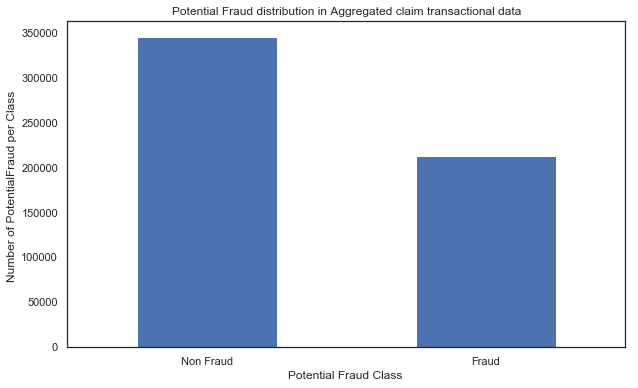

In [329]:
import seaborn as sns
sns.set_style('white',rc={'figure.figsize':(12,8)})
LABELS = ["Non Fraud", "Fraud"]
pd.value_counts(df1['PotentialFraud'], sort = True).plot(kind='bar',rot=0,figsize = (10,6))
plt.title("Potential Fraud distribution in Aggregated claim transactional data")
plt.xticks(range(2), LABELS)
plt.xlabel("Potential Fraud Class ")
plt.ylabel("Number of PotentialFraud per Class ")


In [330]:
##After merge the beneficiary the distribution is very different from before. Therefore we can dig  deeper into 
##the beneficiary table

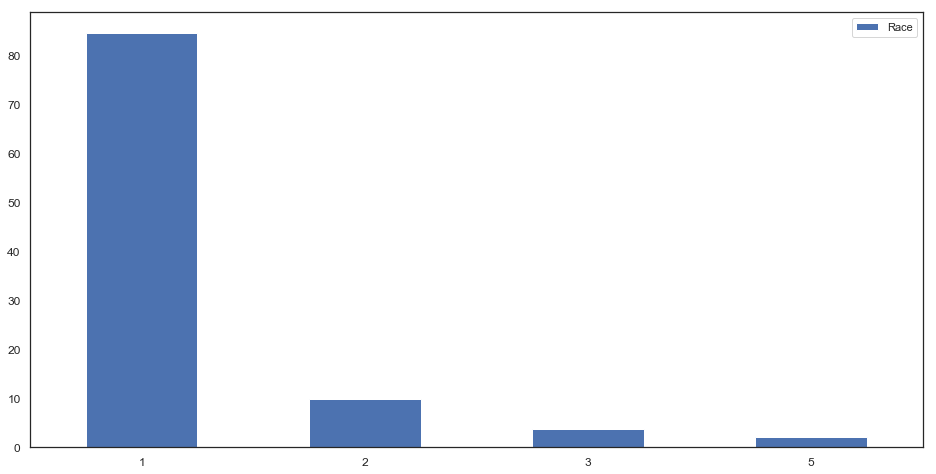

In [331]:
##race
race_count=pd.value_counts(Beneficiary['Race'],sort=True)
(race_count*100/len(Beneficiary)).plot(kind = 'bar', rot=0,figsize=(16,8),fontsize=12,legend=True)
plt.show()

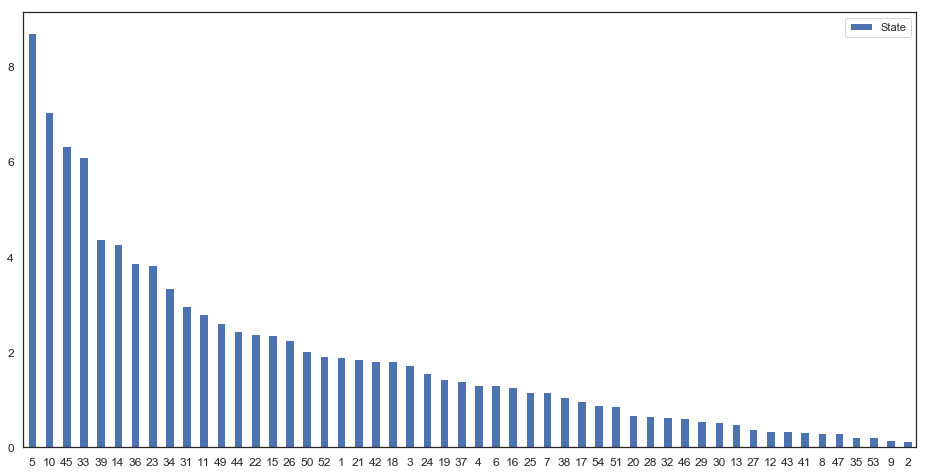

In [332]:
#states
states_count=pd.value_counts(Beneficiary['State'],sort=True)
(states_count*100/len(Beneficiary)).plot(kind = 'bar', rot=0,figsize=(16,8),fontsize=12,legend=True)
plt.show()

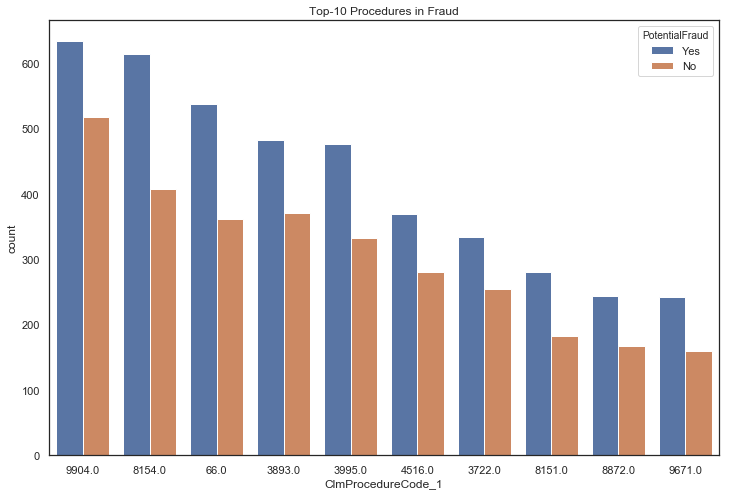

In [333]:
##top procedures
sns.set(rc={'figure.figsize':(12,8)},style='white')
ax=sns.countplot(x='ClmProcedureCode_1',hue='PotentialFraud',data=df1
              ,order=df1.ClmProcedureCode_1.value_counts().iloc[:10].index)

plt.title('Top-10 Procedures in Fraud')
    
plt.show()



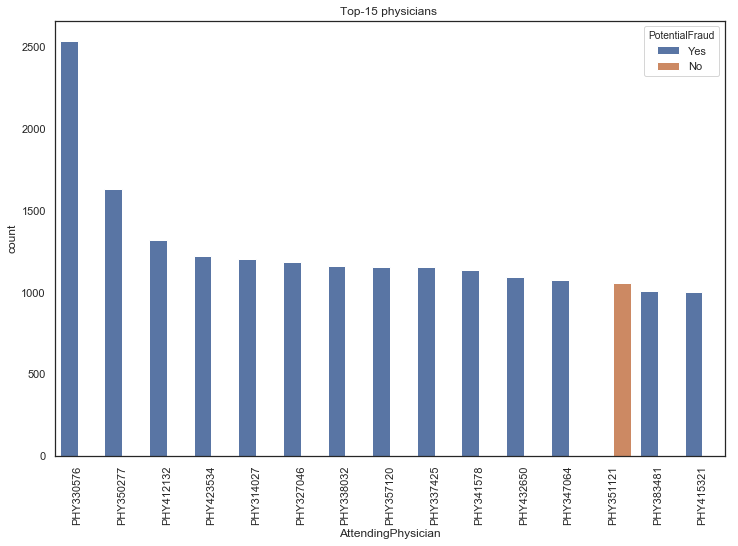

In [334]:
## top physicians


ax= sns.countplot(x='AttendingPhysician',hue='PotentialFraud',data=df1
              ,order=df1.AttendingPhysician.value_counts().iloc[:15].index)

    
plt.title('Top-15 physicians ')
plt.xticks(rotation=90)
plt.show()



In [335]:
##create numeric average columns by provider
df1["PerProviderAvg_InscClaimAmtReimbursed"]=df1.groupby('Provider')['InscClaimAmtReimbursed'].transform('mean')
df1["PerProviderAvg_DeductibleAmtPaid"]=df1.groupby('Provider')['DeductibleAmtPaid'].transform('mean')
df1["PerProviderAvg_IPAnnualReimbursementAmt"]=df1.groupby('Provider')['IPAnnualReimbursementAmt'].transform('mean')
df1["PerProviderAvg_IPAnnualDeductibleAmt"]=df1.groupby('Provider')['IPAnnualDeductibleAmt'].transform('mean')
df1["PerProviderAvg_OPAnnualReimbursementAmt"]=df1.groupby('Provider')['OPAnnualReimbursementAmt'].transform('mean')
df1["PerProviderAvg_OPAnnualDeductibleAmt"]=df1.groupby('Provider')['OPAnnualDeductibleAmt'].transform('mean')
df1["PerProviderAvg_Age"]=df1.groupby('Provider')['Age'].transform('mean')
df1["PerProviderAvg_NoOfMonths_PartACov"]=df1.groupby('Provider')['NoOfMonths_PartACov'].transform('mean')
df1["PerProviderAvg_NoOfMonths_PartBCov"]=df1.groupby('Provider')['NoOfMonths_PartBCov'].transform('mean')
df1["PerProviderAvg_AdmitForDays"]=df1.groupby('Provider')['AdmitForDays'].transform('mean')

In [336]:
df1

BeneID    ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0        BENE11002  CLM624349   2009-10-11  2009-10-11  PRV56011   
1        BENE11004  CLM121801   2009-01-06  2009-01-06  PRV56011   
2        BENE11004  CLM150998   2009-01-22  2009-01-22  PRV56011   
3        BENE11004  CLM173224   2009-02-03  2009-02-03  PRV56011   
4        BENE11004  CLM224741   2009-03-03  2009-03-03  PRV56011   
5        BENE11004  CLM252512   2009-03-18  2009-03-18  PRV56011   
6        BENE11004  CLM322683   2009-04-25  2009-05-15  PRV56011   
7        BENE11004  CLM339500   2009-05-04  2009-05-16  PRV56011   
8        BENE11004  CLM564511   2009-09-06  2009-09-06  PRV56011   
9        BENE11004  CLM720523   2009-12-09  2009-12-09  PRV56011   
10       BENE11004  CLM739666   2009-12-22  2009-12-22  PRV56011   
11       BENE11182  CLM706371   2009-11-30  2009-11-30  PRV56011   
12       BENE11182  CLM748099   2009-12-28  2009-12-28  PRV56011   
13       BENE11263  CLM668228   2009-11-06  2009-11-06  PRV56011   
14       BENE11283  CLM419817   2009-06-17  2009-06-17  PRV56011   
15       BENE11581  CLM307012   2009-04-16  2009-04-16  PRV56011   
16       BENE11581  CLM314437   2009-04-20  2009-04-20  PRV56011   
17       BENE11581  CLM535605   2009-08-20  2009-08-20  PRV56011   
18       BENE11721  CLM293270   2009-04-09  2009-04-09  PRV56011   
19       BENE11721  CLM688592   2009-11-19  2009-11-19  PRV56011   
20       BENE11841  CLM159360   2009-01-26  2009-01-26  PRV56011   
21       BENE11841  CLM674839   2009-11-10  2009-11-30  PRV56011   
22       BENE12084  CLM154716   2009-01-24  2009-01-24  PRV56011   
23       BENE12084  CLM333879   2009-05-01  2009-05-01  PRV56011   
24       BENE12100  CLM387834   2009-05-30  2009-05-30  PRV56011   
25       BENE12100  CLM567164   2009-09-07  2009-09-07  PRV56011   
26       BENE12100  CLM570601   2009-09-09  2009-09-09  PRV56011   
27       BENE12100  CLM582761   2009-09-16  2009-09-26  PRV56011   
28       BENE12100  CLM587945   2009-09-19  2009-10-02  PRV56011   
29       BENE12233  CLM637829   2009-10-19  2009-10-19  PRV56011   
...            ...        ...          ...         ...       ...   
558181  BENE151105  CLM500843   2009-07-31  2009-07-31  PRV52221   
558182  BENE151773  CLM646913   2009-10-24  2009-10-24  PRV52785   
558183  BENE151892   CLM31767   2008-12-31  2009-01-02  PRV51136   
558184  BENE152477  CLM197194   2009-02-15  2009-02-15  PRV54113   
558185  BENE153163  CLM116182   2009-01-02  2009-01-02  PRV55607   
558186  BENE153410  CLM175054   2009-02-03  2009-02-03  PRV56091   
558187  BENE153476  CLM223803   2009-03-02  2009-03-02  PRV52794   
558188  BENE153496  CLM362316   2009-05-16  2009-05-16  PRV52797   
558189  BENE154147  CLM394122   2009-06-02  2009-06-04  PRV54050   
558190  BENE154375   CLM39644   2009-02-22  2009-02-25  PRV51977   
558191  BENE154687  CLM184358   2009-02-08  2009-02-08  PRV54302   
558192  BENE156181   CLM57017   2009-06-24  2009-07-01  PRV55706   
558193  BENE157252  CLM603185   2009-09-28  2009-09-28  PRV57762   
558194  BENE157378  CLM460770   2009-07-09  2009-07-29  PRV51577   
558195  BENE158295  CLM306999   2009-04-16  2009-04-16  PRV53083   
558196  BENE158736  CLM589654   2009-09-20  2009-09-20  PRV56377   
558197  BENE159166   CLM38985   2009-02-18  2009-02-25  PRV51812   
558198   BENE14135   CLM63690   2009-08-13  2009-08-16  PRV52970   
558199   BENE14731   CLM45735   2009-04-06  2009-04-15  PRV57091   
558200  BENE136027   CLM73625   2009-10-27  2009-10-31  PRV57091   
558201  BENE139074   CLM75619   2009-11-12  2009-11-17  PRV57091   
558202  BENE139074   CLM77770   2009-11-29  2009-12-04  PRV57091   
558203   BENE18217   CLM78627   2009-12-06  2009-12-14  PRV55428   
558204   BENE51616   CLM57474   2009-06-28  2009-07-17  PRV52537   
558205   BENE57256   CLM34348   2009-01-18  2009-01-23  PRV55792   
558206   BENE57978   CLM37910   2009-02-11  2009-02-16  PRV53511   
558207   BENE80245   CLM79653   2009-12-15  2009-12-18  PRV51711   


In [337]:
##create numeric average columns by BENEId
df1["PerBeneIDAvg_InscClaimAmtReimbursed"]=df1.groupby('BeneID')['InscClaimAmtReimbursed'].transform('mean')
df1["PerBeneIDAvg_DeductibleAmtPaid"]=df1.groupby('BeneID')['DeductibleAmtPaid'].transform('mean')
df1["PerBeneIDAvg_IPAnnualReimbursementAmt"]=df1.groupby('BeneID')['IPAnnualReimbursementAmt'].transform('mean')
df1["PerBeneIDAvg_IPAnnualDeductibleAmt"]=df1.groupby('BeneID')['IPAnnualDeductibleAmt'].transform('mean')
df1["PerBeneIDAvg_OPAnnualReimbursementAmt"]=df1.groupby('BeneID')['OPAnnualReimbursementAmt'].transform('mean')
df1["PerBeneIDAvg_OPAnnualDeductibleAmt"]=df1.groupby('BeneID')['OPAnnualDeductibleAmt'].transform('mean')
df1["PerBeneIDAvg_AdmitForDays"]=df1.groupby('BeneID')['AdmitForDays'].transform('mean')

In [338]:
df1

BeneID    ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0        BENE11002  CLM624349   2009-10-11  2009-10-11  PRV56011   
1        BENE11004  CLM121801   2009-01-06  2009-01-06  PRV56011   
2        BENE11004  CLM150998   2009-01-22  2009-01-22  PRV56011   
3        BENE11004  CLM173224   2009-02-03  2009-02-03  PRV56011   
4        BENE11004  CLM224741   2009-03-03  2009-03-03  PRV56011   
5        BENE11004  CLM252512   2009-03-18  2009-03-18  PRV56011   
6        BENE11004  CLM322683   2009-04-25  2009-05-15  PRV56011   
7        BENE11004  CLM339500   2009-05-04  2009-05-16  PRV56011   
8        BENE11004  CLM564511   2009-09-06  2009-09-06  PRV56011   
9        BENE11004  CLM720523   2009-12-09  2009-12-09  PRV56011   
10       BENE11004  CLM739666   2009-12-22  2009-12-22  PRV56011   
11       BENE11182  CLM706371   2009-11-30  2009-11-30  PRV56011   
12       BENE11182  CLM748099   2009-12-28  2009-12-28  PRV56011   
13       BENE11263  CLM668228   2009-11-06  2009-11-06  PRV56011   
14       BENE11283  CLM419817   2009-06-17  2009-06-17  PRV56011   
15       BENE11581  CLM307012   2009-04-16  2009-04-16  PRV56011   
16       BENE11581  CLM314437   2009-04-20  2009-04-20  PRV56011   
17       BENE11581  CLM535605   2009-08-20  2009-08-20  PRV56011   
18       BENE11721  CLM293270   2009-04-09  2009-04-09  PRV56011   
19       BENE11721  CLM688592   2009-11-19  2009-11-19  PRV56011   
20       BENE11841  CLM159360   2009-01-26  2009-01-26  PRV56011   
21       BENE11841  CLM674839   2009-11-10  2009-11-30  PRV56011   
22       BENE12084  CLM154716   2009-01-24  2009-01-24  PRV56011   
23       BENE12084  CLM333879   2009-05-01  2009-05-01  PRV56011   
24       BENE12100  CLM387834   2009-05-30  2009-05-30  PRV56011   
25       BENE12100  CLM567164   2009-09-07  2009-09-07  PRV56011   
26       BENE12100  CLM570601   2009-09-09  2009-09-09  PRV56011   
27       BENE12100  CLM582761   2009-09-16  2009-09-26  PRV56011   
28       BENE12100  CLM587945   2009-09-19  2009-10-02  PRV56011   
29       BENE12233  CLM637829   2009-10-19  2009-10-19  PRV56011   
...            ...        ...          ...         ...       ...   
558181  BENE151105  CLM500843   2009-07-31  2009-07-31  PRV52221   
558182  BENE151773  CLM646913   2009-10-24  2009-10-24  PRV52785   
558183  BENE151892   CLM31767   2008-12-31  2009-01-02  PRV51136   
558184  BENE152477  CLM197194   2009-02-15  2009-02-15  PRV54113   
558185  BENE153163  CLM116182   2009-01-02  2009-01-02  PRV55607   
558186  BENE153410  CLM175054   2009-02-03  2009-02-03  PRV56091   
558187  BENE153476  CLM223803   2009-03-02  2009-03-02  PRV52794   
558188  BENE153496  CLM362316   2009-05-16  2009-05-16  PRV52797   
558189  BENE154147  CLM394122   2009-06-02  2009-06-04  PRV54050   
558190  BENE154375   CLM39644   2009-02-22  2009-02-25  PRV51977   
558191  BENE154687  CLM184358   2009-02-08  2009-02-08  PRV54302   
558192  BENE156181   CLM57017   2009-06-24  2009-07-01  PRV55706   
558193  BENE157252  CLM603185   2009-09-28  2009-09-28  PRV57762   
558194  BENE157378  CLM460770   2009-07-09  2009-07-29  PRV51577   
558195  BENE158295  CLM306999   2009-04-16  2009-04-16  PRV53083   
558196  BENE158736  CLM589654   2009-09-20  2009-09-20  PRV56377   
558197  BENE159166   CLM38985   2009-02-18  2009-02-25  PRV51812   
558198   BENE14135   CLM63690   2009-08-13  2009-08-16  PRV52970   
558199   BENE14731   CLM45735   2009-04-06  2009-04-15  PRV57091   
558200  BENE136027   CLM73625   2009-10-27  2009-10-31  PRV57091   
558201  BENE139074   CLM75619   2009-11-12  2009-11-17  PRV57091   
558202  BENE139074   CLM77770   2009-11-29  2009-12-04  PRV57091   
558203   BENE18217   CLM78627   2009-12-06  2009-12-14  PRV55428   
558204   BENE51616   CLM57474   2009-06-28  2009-07-17  PRV52537   
558205   BENE57256   CLM34348   2009-01-18  2009-01-23  PRV55792   
558206   BENE57978   CLM37910   2009-02-11  2009-02-16  PRV53511   
558207   BENE80245   CLM79653   2009-12-15  2009-12-18  PRV51711   


In [339]:
##create numeric average columns by physician
df1["PerOperatingPhysicianAvg_InscClaimAmtReimbursed"]=df1.groupby('OperatingPhysician')['InscClaimAmtReimbursed'].transform('mean')
df1["PerOperatingPhysicianAvg_DeductibleAmtPaid"]=df1.groupby('OperatingPhysician')['DeductibleAmtPaid'].transform('mean')
df1["PerOperatingPhysicianAvg_IPAnnualReimbursementAmt"]=df1.groupby('OperatingPhysician')['IPAnnualReimbursementAmt'].transform('mean')
df1["PerOperatingPhysicianAvg_IPAnnualDeductibleAmt"]=df1.groupby('OperatingPhysician')['IPAnnualDeductibleAmt'].transform('mean')
df1["PerOperatingPhysicianAvg_OPAnnualReimbursementAmt"]=df1.groupby('OperatingPhysician')['OPAnnualReimbursementAmt'].transform('mean')
df1["PerOperatingPhysicianAvg_OPAnnualDeductibleAmt"]=df1.groupby('OperatingPhysician')['OPAnnualDeductibleAmt'].transform('mean')
df1["PerOperatingPhysicianAvg_AdmitForDays"]=df1.groupby('OperatingPhysician')['AdmitForDays'].transform('mean')

In [340]:
df1

BeneID    ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0        BENE11002  CLM624349   2009-10-11  2009-10-11  PRV56011   
1        BENE11004  CLM121801   2009-01-06  2009-01-06  PRV56011   
2        BENE11004  CLM150998   2009-01-22  2009-01-22  PRV56011   
3        BENE11004  CLM173224   2009-02-03  2009-02-03  PRV56011   
4        BENE11004  CLM224741   2009-03-03  2009-03-03  PRV56011   
5        BENE11004  CLM252512   2009-03-18  2009-03-18  PRV56011   
6        BENE11004  CLM322683   2009-04-25  2009-05-15  PRV56011   
7        BENE11004  CLM339500   2009-05-04  2009-05-16  PRV56011   
8        BENE11004  CLM564511   2009-09-06  2009-09-06  PRV56011   
9        BENE11004  CLM720523   2009-12-09  2009-12-09  PRV56011   
10       BENE11004  CLM739666   2009-12-22  2009-12-22  PRV56011   
11       BENE11182  CLM706371   2009-11-30  2009-11-30  PRV56011   
12       BENE11182  CLM748099   2009-12-28  2009-12-28  PRV56011   
13       BENE11263  CLM668228   2009-11-06  2009-11-06  PRV56011   
14       BENE11283  CLM419817   2009-06-17  2009-06-17  PRV56011   
15       BENE11581  CLM307012   2009-04-16  2009-04-16  PRV56011   
16       BENE11581  CLM314437   2009-04-20  2009-04-20  PRV56011   
17       BENE11581  CLM535605   2009-08-20  2009-08-20  PRV56011   
18       BENE11721  CLM293270   2009-04-09  2009-04-09  PRV56011   
19       BENE11721  CLM688592   2009-11-19  2009-11-19  PRV56011   
20       BENE11841  CLM159360   2009-01-26  2009-01-26  PRV56011   
21       BENE11841  CLM674839   2009-11-10  2009-11-30  PRV56011   
22       BENE12084  CLM154716   2009-01-24  2009-01-24  PRV56011   
23       BENE12084  CLM333879   2009-05-01  2009-05-01  PRV56011   
24       BENE12100  CLM387834   2009-05-30  2009-05-30  PRV56011   
25       BENE12100  CLM567164   2009-09-07  2009-09-07  PRV56011   
26       BENE12100  CLM570601   2009-09-09  2009-09-09  PRV56011   
27       BENE12100  CLM582761   2009-09-16  2009-09-26  PRV56011   
28       BENE12100  CLM587945   2009-09-19  2009-10-02  PRV56011   
29       BENE12233  CLM637829   2009-10-19  2009-10-19  PRV56011   
...            ...        ...          ...         ...       ...   
558181  BENE151105  CLM500843   2009-07-31  2009-07-31  PRV52221   
558182  BENE151773  CLM646913   2009-10-24  2009-10-24  PRV52785   
558183  BENE151892   CLM31767   2008-12-31  2009-01-02  PRV51136   
558184  BENE152477  CLM197194   2009-02-15  2009-02-15  PRV54113   
558185  BENE153163  CLM116182   2009-01-02  2009-01-02  PRV55607   
558186  BENE153410  CLM175054   2009-02-03  2009-02-03  PRV56091   
558187  BENE153476  CLM223803   2009-03-02  2009-03-02  PRV52794   
558188  BENE153496  CLM362316   2009-05-16  2009-05-16  PRV52797   
558189  BENE154147  CLM394122   2009-06-02  2009-06-04  PRV54050   
558190  BENE154375   CLM39644   2009-02-22  2009-02-25  PRV51977   
558191  BENE154687  CLM184358   2009-02-08  2009-02-08  PRV54302   
558192  BENE156181   CLM57017   2009-06-24  2009-07-01  PRV55706   
558193  BENE157252  CLM603185   2009-09-28  2009-09-28  PRV57762   
558194  BENE157378  CLM460770   2009-07-09  2009-07-29  PRV51577   
558195  BENE158295  CLM306999   2009-04-16  2009-04-16  PRV53083   
558196  BENE158736  CLM589654   2009-09-20  2009-09-20  PRV56377   
558197  BENE159166   CLM38985   2009-02-18  2009-02-25  PRV51812   
558198   BENE14135   CLM63690   2009-08-13  2009-08-16  PRV52970   
558199   BENE14731   CLM45735   2009-04-06  2009-04-15  PRV57091   
558200  BENE136027   CLM73625   2009-10-27  2009-10-31  PRV57091   
558201  BENE139074   CLM75619   2009-11-12  2009-11-17  PRV57091   
558202  BENE139074   CLM77770   2009-11-29  2009-12-04  PRV57091   
558203   BENE18217   CLM78627   2009-12-06  2009-12-14  PRV55428   
558204   BENE51616   CLM57474   2009-06-28  2009-07-17  PRV52537   
558205   BENE57256   CLM34348   2009-01-18  2009-01-23  PRV55792   
558206   BENE57978   CLM37910   2009-02-11  2009-02-16  PRV53511   
558207   BENE80245   CLM79653   2009-12-15  2009-12-18  PRV51711   


In [341]:
##create numeric average columns by DiagnosisGroupCode
df1["PerDiagnosisGroupCodeAvg_InscClaimAmtReimbursed"]=df1.groupby('DiagnosisGroupCode')['InscClaimAmtReimbursed'].transform('mean')
df1["PerDiagnosisGroupCodeAvg_DeductibleAmtPaid"]=df1.groupby('DiagnosisGroupCode')['DeductibleAmtPaid'].transform('mean')
df1["PerDiagnosisGroupCodeAvg_IPAnnualReimbursementAmt"]=df1.groupby('DiagnosisGroupCode')['IPAnnualReimbursementAmt'].transform('mean')
df1["PerDiagnosisGroupCodeAvg_IPAnnualDeductibleAmt"]=df1.groupby('DiagnosisGroupCode')['IPAnnualDeductibleAmt'].transform('mean')
df1["PerDiagnosisGroupCodeAvg_OPAnnualReimbursementAmt"]=df1.groupby('DiagnosisGroupCode')['OPAnnualReimbursementAmt'].transform('mean')
df1["PerDiagnosisGroupCodeAvg_OPAnnualDeductibleAmt"]=df1.groupby('DiagnosisGroupCode')['OPAnnualDeductibleAmt'].transform('mean')
df1["PerDiagnosisGroupCodeAvg_AdmitForDays"]=df1.groupby('DiagnosisGroupCode')['AdmitForDays'].transform('mean')

In [342]:
##create numeric average columns by ClmAdmitDiagnosisCode
df1["PerClmAdmitDiagnosisCodeAvg_InscClaimAmtReimbursed"]=df1.groupby('ClmAdmitDiagnosisCode')['InscClaimAmtReimbursed'].transform('mean')
df1["PerClmAdmitDiagnosisCodeAvg_DeductibleAmtPaid"]=df1.groupby('ClmAdmitDiagnosisCode')['DeductibleAmtPaid'].transform('mean')
df1["PerClmAdmitDiagnosisCodeAvg_IPAnnualReimbursementAmt"]=df1.groupby('ClmAdmitDiagnosisCode')['IPAnnualReimbursementAmt'].transform('mean')
df1["PerClmAdmitDiagnosisCodeAvg_IPAnnualDeductibleAmt"]=df1.groupby('ClmAdmitDiagnosisCode')['IPAnnualDeductibleAmt'].transform('mean')
df1["PerClmAdmitDiagnosisCodeAvg_OPAnnualReimbursementAmt"]=df1.groupby('ClmAdmitDiagnosisCode')['OPAnnualReimbursementAmt'].transform('mean')
df1["PerClmAdmitDiagnosisCodeAvg_OPAnnualDeductibleAmt"]=df1.groupby('ClmAdmitDiagnosisCode')['OPAnnualDeductibleAmt'].transform('mean')
df1["PerClmAdmitDiagnosisCodeAvg_AdmitForDays"]=df1.groupby('ClmAdmitDiagnosisCode')['AdmitForDays'].transform('mean')

In [343]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 96 columns):
BeneID                                                  558211 non-null object
ClaimID                                                 558211 non-null object
ClaimStartDt                                            558211 non-null object
ClaimEndDt                                              558211 non-null object
Provider                                                558211 non-null object
InscClaimAmtReimbursed                                  558211 non-null int64
AttendingPhysician                                      556703 non-null object
OperatingPhysician                                      114447 non-null object
OtherPhysician                                          199736 non-null object
ClmDiagnosisCode_1                                      547758 non-null object
ClmDiagnosisCode_2                                      362605 non-null object
ClmDiagnosisCode_3   

In [344]:
## too many null value in ClmDiagnosisCode_5 to 10 so we chose ClmDiagnosisCode 1 to_4
##also, too many null value in ClmProcedureCode_4 to 6  so we chose ClmProcedureCode_1 to 3

In [345]:
df1["PerClmDiagnosisCode_1Avg_InscClaimAmtReimbursed"]=df1.groupby('ClmDiagnosisCode_1')['InscClaimAmtReimbursed'].transform('mean')
df1["PerClmDiagnosisCode_1Avg_DeductibleAmtPaid"]=df1.groupby('ClmDiagnosisCode_1')['DeductibleAmtPaid'].transform('mean')
df1["PerClmDiagnosisCode_1Avg_IPAnnualReimbursementAmt"]=df1.groupby('ClmDiagnosisCode_1')['IPAnnualReimbursementAmt'].transform('mean')
df1["PerClmDiagnosisCode_1Avg_IPAnnualDeductibleAmt"]=df1.groupby('ClmDiagnosisCode_1')['IPAnnualDeductibleAmt'].transform('mean')
df1["PerClmDiagnosisCode_1Avg_OPAnnualReimbursementAmt"]=df1.groupby('ClmDiagnosisCode_1')['OPAnnualReimbursementAmt'].transform('mean')
df1["PerClmDiagnosisCode_1Avg_OPAnnualDeductibleAmt"]=df1.groupby('ClmDiagnosisCode_1')['OPAnnualDeductibleAmt'].transform('mean')
df1["PerClmDiagnosisCode_1Avg_AdmitForDays"]=df1.groupby('ClmDiagnosisCode_1')['AdmitForDays'].transform('mean')

df1["PerClmDiagnosisCode_2Avg_InscClaimAmtReimbursed"]=df1.groupby('ClmDiagnosisCode_2')['InscClaimAmtReimbursed'].transform('mean')
df1["PerClmDiagnosisCode_2Avg_DeductibleAmtPaid"]=df1.groupby('ClmDiagnosisCode_2')['DeductibleAmtPaid'].transform('mean')
df1["PerClmDiagnosisCode_2Avg_IPAnnualReimbursementAmt"]=df1.groupby('ClmDiagnosisCode_2')['IPAnnualReimbursementAmt'].transform('mean')
df1["PerClmDiagnosisCode_2Avg_IPAnnualDeductibleAmt"]=df1.groupby('ClmDiagnosisCode_2')['IPAnnualDeductibleAmt'].transform('mean')
df1["PerClmDiagnosisCode_2Avg_OPAnnualReimbursementAmt"]=df1.groupby('ClmDiagnosisCode_2')['OPAnnualReimbursementAmt'].transform('mean')
df1["PerClmDiagnosisCode_2Avg_OPAnnualDeductibleAmt"]=df1.groupby('ClmDiagnosisCode_2')['OPAnnualDeductibleAmt'].transform('mean')
df1["PerClmDiagnosisCode_2Avg_AdmitForDays"]=df1.groupby('ClmDiagnosisCode_2')['AdmitForDays'].transform('mean')

df1["PerClmDiagnosisCode_3Avg_InscClaimAmtReimbursed"]=df1.groupby('ClmDiagnosisCode_3')['InscClaimAmtReimbursed'].transform('mean')
df1["PerClmDiagnosisCode_3Avg_DeductibleAmtPaid"]=df1.groupby('ClmDiagnosisCode_3')['DeductibleAmtPaid'].transform('mean')
df1["PerClmDiagnosisCode_3Avg_IPAnnualReimbursementAmt"]=df1.groupby('ClmDiagnosisCode_3')['IPAnnualReimbursementAmt'].transform('mean')
df1["PerClmDiagnosisCode_3Avg_IPAnnualDeductibleAmt"]=df1.groupby('ClmDiagnosisCode_3')['IPAnnualDeductibleAmt'].transform('mean')
df1["PerClmDiagnosisCode_3Avg_OPAnnualReimbursementAmt"]=df1.groupby('ClmDiagnosisCode_3')['OPAnnualReimbursementAmt'].transform('mean')
df1["PerClmDiagnosisCode_3Avg_OPAnnualDeductibleAmt"]=df1.groupby('ClmDiagnosisCode_3')['OPAnnualDeductibleAmt'].transform('mean')
df1["PerClmDiagnosisCode_3Avg_AdmitForDays"]=df1.groupby('ClmDiagnosisCode_3')['AdmitForDays'].transform('mean')

df1["PerClmDiagnosisCode_4Avg_InscClaimAmtReimbursed"]=df1.groupby('ClmDiagnosisCode_4')['InscClaimAmtReimbursed'].transform('mean')
df1["PerClmDiagnosisCode_4Avg_DeductibleAmtPaid"]=df1.groupby('ClmDiagnosisCode_4')['DeductibleAmtPaid'].transform('mean')
df1["PerClmDiagnosisCode_4Avg_IPAnnualReimbursementAmt"]=df1.groupby('ClmDiagnosisCode_4')['IPAnnualReimbursementAmt'].transform('mean')
df1["PerClmDiagnosisCode_4Avg_IPAnnualDeductibleAmt"]=df1.groupby('ClmDiagnosisCode_4')['IPAnnualDeductibleAmt'].transform('mean')
df1["PerClmDiagnosisCode_4Avg_OPAnnualReimbursementAmt"]=df1.groupby('ClmDiagnosisCode_4')['OPAnnualReimbursementAmt'].transform('mean')
df1["PerClmDiagnosisCode_4Avg_OPAnnualDeductibleAmt"]=df1.groupby('ClmDiagnosisCode_4')['OPAnnualDeductibleAmt'].transform('mean')
df1["PerClmDiagnosisCode_4Avg_AdmitForDays"]=df1.groupby('ClmDiagnosisCode_4')['AdmitForDays'].transform('mean')

df1["PerClmProcedureCode_1Avg_InscClaimAmtReimbursed"]=df1.groupby('ClmProcedureCode_1')['InscClaimAmtReimbursed'].transform('mean')
df1["PerClmProcedureCode_1Avg_DeductibleAmtPaid"]=df1.groupby('ClmProcedureCode_1')['DeductibleAmtPaid'].transform('mean')
df1["PerClmProcedureCode_1Avg_IPAnnualReimbursementAmt"]=df1.groupby('ClmProcedureCode_1')['IPAnnualReimbursementAmt'].transform('mean')
df1["PerClmProcedureCode_1Avg_IPAnnualDeductibleAmt"]=df1.groupby('ClmProcedureCode_1')['IPAnnualDeductibleAmt'].transform('mean')
df1["PerClmProcedureCode_1Avg_OPAnnualReimbursementAmt"]=df1.groupby('ClmProcedureCode_1')['OPAnnualReimbursementAmt'].transform('mean')
df1["PerClmProcedureCode_1Avg_OPAnnualDeductibleAmt"]=df1.groupby('ClmProcedureCode_1')['OPAnnualDeductibleAmt'].transform('mean')
df1["PerClmProcedureCode_1Avg_AdmitForDays"]=df1.groupby('ClmProcedureCode_1')['AdmitForDays'].transform('mean')

df1["PerClmProcedureCode_2Avg_InscClaimAmtReimbursed"]=df1.groupby('ClmProcedureCode_2')['InscClaimAmtReimbursed'].transform('mean')
df1["PerClmProcedureCode_2Avg_DeductibleAmtPaid"]=df1.groupby('ClmProcedureCode_2')['DeductibleAmtPaid'].transform('mean')
df1["PerClmProcedureCode_2Avg_IPAnnualReimbursementAmt"]=df1.groupby('ClmProcedureCode_2')['IPAnnualReimbursementAmt'].transform('mean')
df1["PerClmProcedureCode_2Avg_IPAnnualDeductibleAmt"]=df1.groupby('ClmProcedureCode_2')['IPAnnualDeductibleAmt'].transform('mean')
df1["PerClmProcedureCode_2Avg_OPAnnualReimbursementAmt"]=df1.groupby('ClmProcedureCode_2')['OPAnnualReimbursementAmt'].transform('mean')
df1["PerClmProcedureCode_2Avg_OPAnnualDeductibleAmt"]=df1.groupby('ClmProcedureCode_2')['OPAnnualDeductibleAmt'].transform('mean')
df1["PerClmProcedureCode_2Avg_AdmitForDays"]=df1.groupby('ClmProcedureCode_2')['AdmitForDays'].transform('mean')

df1["PerClmProcedureCode_3Avg_InscClaimAmtReimbursed"]=df1.groupby('ClmProcedureCode_3')['InscClaimAmtReimbursed'].transform('mean')
df1["PerClmProcedureCode_3Avg_DeductibleAmtPaid"]=df1.groupby('ClmProcedureCode_3')['DeductibleAmtPaid'].transform('mean')
df1["PerClmProcedureCode_3Avg_IPAnnualReimbursementAmt"]=df1.groupby('ClmProcedureCode_3')['IPAnnualReimbursementAmt'].transform('mean')
df1["PerClmProcedureCode_3Avg_IPAnnualDeductibleAmt"]=df1.groupby('ClmProcedureCode_3')['IPAnnualDeductibleAmt'].transform('mean')
df1["PerClmProcedureCode_3Avg_OPAnnualReimbursementAmt"]=df1.groupby('ClmProcedureCode_3')['OPAnnualReimbursementAmt'].transform('mean')
df1["PerClmProcedureCode_3Avg_OPAnnualDeductibleAmt"]=df1.groupby('ClmProcedureCode_3')['OPAnnualDeductibleAmt'].transform('mean')
df1["PerClmProcedureCode_3Avg_AdmitForDays"]=df1.groupby('ClmProcedureCode_3')['AdmitForDays'].transform('mean')


In [346]:
df1["PerClmProcedureCode_3Avg_InscClaimAmtReimbursed"].isnull().sum()

557242

In [348]:
df1.shape

(558211, 145)

In [349]:
df1

BeneID    ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0        BENE11002  CLM624349   2009-10-11  2009-10-11  PRV56011   
1        BENE11004  CLM121801   2009-01-06  2009-01-06  PRV56011   
2        BENE11004  CLM150998   2009-01-22  2009-01-22  PRV56011   
3        BENE11004  CLM173224   2009-02-03  2009-02-03  PRV56011   
4        BENE11004  CLM224741   2009-03-03  2009-03-03  PRV56011   
5        BENE11004  CLM252512   2009-03-18  2009-03-18  PRV56011   
6        BENE11004  CLM322683   2009-04-25  2009-05-15  PRV56011   
7        BENE11004  CLM339500   2009-05-04  2009-05-16  PRV56011   
8        BENE11004  CLM564511   2009-09-06  2009-09-06  PRV56011   
9        BENE11004  CLM720523   2009-12-09  2009-12-09  PRV56011   
10       BENE11004  CLM739666   2009-12-22  2009-12-22  PRV56011   
11       BENE11182  CLM706371   2009-11-30  2009-11-30  PRV56011   
12       BENE11182  CLM748099   2009-12-28  2009-12-28  PRV56011   
13       BENE11263  CLM668228   2009-11-06  2009-11-06  PRV56011   
14       BENE11283  CLM419817   2009-06-17  2009-06-17  PRV56011   
15       BENE11581  CLM307012   2009-04-16  2009-04-16  PRV56011   
16       BENE11581  CLM314437   2009-04-20  2009-04-20  PRV56011   
17       BENE11581  CLM535605   2009-08-20  2009-08-20  PRV56011   
18       BENE11721  CLM293270   2009-04-09  2009-04-09  PRV56011   
19       BENE11721  CLM688592   2009-11-19  2009-11-19  PRV56011   
20       BENE11841  CLM159360   2009-01-26  2009-01-26  PRV56011   
21       BENE11841  CLM674839   2009-11-10  2009-11-30  PRV56011   
22       BENE12084  CLM154716   2009-01-24  2009-01-24  PRV56011   
23       BENE12084  CLM333879   2009-05-01  2009-05-01  PRV56011   
24       BENE12100  CLM387834   2009-05-30  2009-05-30  PRV56011   
25       BENE12100  CLM567164   2009-09-07  2009-09-07  PRV56011   
26       BENE12100  CLM570601   2009-09-09  2009-09-09  PRV56011   
27       BENE12100  CLM582761   2009-09-16  2009-09-26  PRV56011   
28       BENE12100  CLM587945   2009-09-19  2009-10-02  PRV56011   
29       BENE12233  CLM637829   2009-10-19  2009-10-19  PRV56011   
...            ...        ...          ...         ...       ...   
558181  BENE151105  CLM500843   2009-07-31  2009-07-31  PRV52221   
558182  BENE151773  CLM646913   2009-10-24  2009-10-24  PRV52785   
558183  BENE151892   CLM31767   2008-12-31  2009-01-02  PRV51136   
558184  BENE152477  CLM197194   2009-02-15  2009-02-15  PRV54113   
558185  BENE153163  CLM116182   2009-01-02  2009-01-02  PRV55607   
558186  BENE153410  CLM175054   2009-02-03  2009-02-03  PRV56091   
558187  BENE153476  CLM223803   2009-03-02  2009-03-02  PRV52794   
558188  BENE153496  CLM362316   2009-05-16  2009-05-16  PRV52797   
558189  BENE154147  CLM394122   2009-06-02  2009-06-04  PRV54050   
558190  BENE154375   CLM39644   2009-02-22  2009-02-25  PRV51977   
558191  BENE154687  CLM184358   2009-02-08  2009-02-08  PRV54302   
558192  BENE156181   CLM57017   2009-06-24  2009-07-01  PRV55706   
558193  BENE157252  CLM603185   2009-09-28  2009-09-28  PRV57762   
558194  BENE157378  CLM460770   2009-07-09  2009-07-29  PRV51577   
558195  BENE158295  CLM306999   2009-04-16  2009-04-16  PRV53083   
558196  BENE158736  CLM589654   2009-09-20  2009-09-20  PRV56377   
558197  BENE159166   CLM38985   2009-02-18  2009-02-25  PRV51812   
558198   BENE14135   CLM63690   2009-08-13  2009-08-16  PRV52970   
558199   BENE14731   CLM45735   2009-04-06  2009-04-15  PRV57091   
558200  BENE136027   CLM73625   2009-10-27  2009-10-31  PRV57091   
558201  BENE139074   CLM75619   2009-11-12  2009-11-17  PRV57091   
558202  BENE139074   CLM77770   2009-11-29  2009-12-04  PRV57091   
558203   BENE18217   CLM78627   2009-12-06  2009-12-14  PRV55428   
558204   BENE51616   CLM57474   2009-06-28  2009-07-17  PRV52537   
558205   BENE57256   CLM34348   2009-01-18  2009-01-23  PRV55792   
558206   BENE57978   CLM37910   2009-02-11  2009-02-16  PRV53511   
558207   BENE80245   CLM79653   2009-12-15  2009-12-18  PRV51711   


In [350]:
##replace all null by 0
num_cols=df1.select_dtypes([np.number]).columns


df1[num_cols]=df1[num_cols].fillna(value=0)

In [351]:
df1

BeneID    ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0        BENE11002  CLM624349   2009-10-11  2009-10-11  PRV56011   
1        BENE11004  CLM121801   2009-01-06  2009-01-06  PRV56011   
2        BENE11004  CLM150998   2009-01-22  2009-01-22  PRV56011   
3        BENE11004  CLM173224   2009-02-03  2009-02-03  PRV56011   
4        BENE11004  CLM224741   2009-03-03  2009-03-03  PRV56011   
5        BENE11004  CLM252512   2009-03-18  2009-03-18  PRV56011   
6        BENE11004  CLM322683   2009-04-25  2009-05-15  PRV56011   
7        BENE11004  CLM339500   2009-05-04  2009-05-16  PRV56011   
8        BENE11004  CLM564511   2009-09-06  2009-09-06  PRV56011   
9        BENE11004  CLM720523   2009-12-09  2009-12-09  PRV56011   
10       BENE11004  CLM739666   2009-12-22  2009-12-22  PRV56011   
11       BENE11182  CLM706371   2009-11-30  2009-11-30  PRV56011   
12       BENE11182  CLM748099   2009-12-28  2009-12-28  PRV56011   
13       BENE11263  CLM668228   2009-11-06  2009-11-06  PRV56011   
14       BENE11283  CLM419817   2009-06-17  2009-06-17  PRV56011   
15       BENE11581  CLM307012   2009-04-16  2009-04-16  PRV56011   
16       BENE11581  CLM314437   2009-04-20  2009-04-20  PRV56011   
17       BENE11581  CLM535605   2009-08-20  2009-08-20  PRV56011   
18       BENE11721  CLM293270   2009-04-09  2009-04-09  PRV56011   
19       BENE11721  CLM688592   2009-11-19  2009-11-19  PRV56011   
20       BENE11841  CLM159360   2009-01-26  2009-01-26  PRV56011   
21       BENE11841  CLM674839   2009-11-10  2009-11-30  PRV56011   
22       BENE12084  CLM154716   2009-01-24  2009-01-24  PRV56011   
23       BENE12084  CLM333879   2009-05-01  2009-05-01  PRV56011   
24       BENE12100  CLM387834   2009-05-30  2009-05-30  PRV56011   
25       BENE12100  CLM567164   2009-09-07  2009-09-07  PRV56011   
26       BENE12100  CLM570601   2009-09-09  2009-09-09  PRV56011   
27       BENE12100  CLM582761   2009-09-16  2009-09-26  PRV56011   
28       BENE12100  CLM587945   2009-09-19  2009-10-02  PRV56011   
29       BENE12233  CLM637829   2009-10-19  2009-10-19  PRV56011   
...            ...        ...          ...         ...       ...   
558181  BENE151105  CLM500843   2009-07-31  2009-07-31  PRV52221   
558182  BENE151773  CLM646913   2009-10-24  2009-10-24  PRV52785   
558183  BENE151892   CLM31767   2008-12-31  2009-01-02  PRV51136   
558184  BENE152477  CLM197194   2009-02-15  2009-02-15  PRV54113   
558185  BENE153163  CLM116182   2009-01-02  2009-01-02  PRV55607   
558186  BENE153410  CLM175054   2009-02-03  2009-02-03  PRV56091   
558187  BENE153476  CLM223803   2009-03-02  2009-03-02  PRV52794   
558188  BENE153496  CLM362316   2009-05-16  2009-05-16  PRV52797   
558189  BENE154147  CLM394122   2009-06-02  2009-06-04  PRV54050   
558190  BENE154375   CLM39644   2009-02-22  2009-02-25  PRV51977   
558191  BENE154687  CLM184358   2009-02-08  2009-02-08  PRV54302   
558192  BENE156181   CLM57017   2009-06-24  2009-07-01  PRV55706   
558193  BENE157252  CLM603185   2009-09-28  2009-09-28  PRV57762   
558194  BENE157378  CLM460770   2009-07-09  2009-07-29  PRV51577   
558195  BENE158295  CLM306999   2009-04-16  2009-04-16  PRV53083   
558196  BENE158736  CLM589654   2009-09-20  2009-09-20  PRV56377   
558197  BENE159166   CLM38985   2009-02-18  2009-02-25  PRV51812   
558198   BENE14135   CLM63690   2009-08-13  2009-08-16  PRV52970   
558199   BENE14731   CLM45735   2009-04-06  2009-04-15  PRV57091   
558200  BENE136027   CLM73625   2009-10-27  2009-10-31  PRV57091   
558201  BENE139074   CLM75619   2009-11-12  2009-11-17  PRV57091   
558202  BENE139074   CLM77770   2009-11-29  2009-12-04  PRV57091   
558203   BENE18217   CLM78627   2009-12-06  2009-12-14  PRV55428   
558204   BENE51616   CLM57474   2009-06-28  2009-07-17  PRV52537   
558205   BENE57256   CLM34348   2009-01-18  2009-01-23  PRV55792   
558206   BENE57978   CLM37910   2009-02-11  2009-02-16  PRV53511   
558207   BENE80245   CLM79653   2009-12-15  2009-12-18  PRV51711   


In [352]:
df1.isnull().sum()

BeneID                                                    0
ClaimID                                                   0
ClaimStartDt                                              0
ClaimEndDt                                                0
Provider                                                  0
InscClaimAmtReimbursed                                    0
AttendingPhysician                                     1508
OperatingPhysician                                   443764
OtherPhysician                                       358475
ClmDiagnosisCode_1                                    10453
ClmDiagnosisCode_2                                   195606
ClmDiagnosisCode_3                                   315156
ClmDiagnosisCode_4                                   393675
ClmDiagnosisCode_5                                   446287
ClmDiagnosisCode_6                                   473819
ClmDiagnosisCode_7                                   492034
ClmDiagnosisCode_8                      

In [353]:
##select features
cols=df1.columns
cols[:58]

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode', 'AdmissionDt', 'DischargeDt',
       'DiagnosisGroupCode', 'AdmitForDays', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depressi

In [354]:
remove_columns=['BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6',
       'ClmAdmitDiagnosisCode', 'AdmissionDt',
       'DischargeDt', 'DiagnosisGroupCode','DOB', 'DOD',
        'State', 'County']
df1=df1.drop(axis=1,columns=remove_columns)

In [355]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Columns: 114 entries, Provider to PerClmProcedureCode_3Avg_AdmitForDays
dtypes: float64(87), int64(24), object(3)
memory usage: 489.8+ MB


In [356]:
df1

Provider  InscClaimAmtReimbursed  DeductibleAmtPaid  AdmitForDays  \
0       PRV56011                      30                0.0           0.0   
1       PRV56011                      40                0.0           0.0   
2       PRV56011                     200                0.0           0.0   
3       PRV56011                      20                0.0           0.0   
4       PRV56011                      40                0.0           0.0   
5       PRV56011                     200                0.0           0.0   
6       PRV56011                      60                0.0           0.0   
7       PRV56011                     500                0.0           0.0   
8       PRV56011                     400                0.0           0.0   
9       PRV56011                     100                0.0           0.0   
10      PRV56011                     100                0.0           0.0   
11      PRV56011                      60                0.0           0.0   
12      PRV56011                      10                0.0           0.0   
13      PRV56011                     400                0.0           0.0   
14      PRV56011                     200                0.0           0.0   
15      PRV56011                     500                0.0           0.0   
16      PRV56011                      20                0.0           0.0   
17      PRV56011                       0                0.0           0.0   
18      PRV56011                      40              100.0           0.0   
19      PRV56011                     100                0.0           0.0   
20      PRV56011                      30                0.0           0.0   
21      PRV56011                      60                0.0           0.0   
22      PRV56011                     100                0.0           0.0   
23      PRV56011                      70                0.0           0.0   
24      PRV56011                      10                0.0           0.0   
25      PRV56011                     300                0.0           0.0   
26      PRV56011                    1000                0.0           0.0   
27      PRV56011                      20                0.0           0.0   
28      PRV56011                      40                0.0           0.0   
29      PRV56011                      90                0.0           0.0   
...          ...                     ...                ...           ...   
558181  PRV52221                      10                0.0           0.0   
558182  PRV52785                      60                0.0           0.0   
558183  PRV51136                   20000             1068.0           3.0   
558184  PRV54113                      60                0.0           0.0   
558185  PRV55607                      40                0.0           0.0   
558186  PRV56091                     200                0.0           0.0   
558187  PRV52794                      30                0.0           0.0   
558188  PRV52797                     300                0.0           0.0   
558189  PRV54050                     500                0.0           0.0   
558190  PRV51977                    8000             1068.0           4.0   
558191  PRV54302                    3300                0.0           0.0   
558192  PRV55706                   12000             1068.0           8.0   
558193  PRV57762                    1900                0.0           0.0   
558194  PRV51577                    2100                0.0           0.0   
558195  PRV53083                      10                0.0           0.0   
558196  PRV56377                      60                0.0           0.0   
558197  PRV51812                    6000             1068.0           8.0   
558198  PRV52970                    4000             1068.0           4.0   
558199  PRV57091                   12000             1068.0          10.0   
558200  PRV57091                    2000             1068.0           5.0   
5582

In [357]:
df1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 114 columns):
Provider                                                object
InscClaimAmtReimbursed                                  int64
DeductibleAmtPaid                                       float64
AdmitForDays                                            float64
Gender                                                  int64
Race                                                    int64
RenalDiseaseIndicator                                   object
NoOfMonths_PartACov                                     int64
NoOfMonths_PartBCov                                     int64
ChronicCond_Alzheimer                                   int64
ChronicCond_Heartfailure                                int64
ChronicCond_KidneyDisease                               int64
ChronicCond_Cancer                                      int64
ChronicCond_ObstrPulmonary                              int64
ChronicCond_De

In [358]:
df1.Gender=df1.Gender.astype('category')
df1.Race=df1.Race.astype('category')

In [359]:
df1=pd.get_dummies(df1,columns=['Gender','Race'],drop_first=True)

In [360]:
df1

Provider  InscClaimAmtReimbursed  DeductibleAmtPaid  AdmitForDays  \
0       PRV56011                      30                0.0           0.0   
1       PRV56011                      40                0.0           0.0   
2       PRV56011                     200                0.0           0.0   
3       PRV56011                      20                0.0           0.0   
4       PRV56011                      40                0.0           0.0   
5       PRV56011                     200                0.0           0.0   
6       PRV56011                      60                0.0           0.0   
7       PRV56011                     500                0.0           0.0   
8       PRV56011                     400                0.0           0.0   
9       PRV56011                     100                0.0           0.0   
10      PRV56011                     100                0.0           0.0   
11      PRV56011                      60                0.0           0.0   
12      PRV56011                      10                0.0           0.0   
13      PRV56011                     400                0.0           0.0   
14      PRV56011                     200                0.0           0.0   
15      PRV56011                     500                0.0           0.0   
16      PRV56011                      20                0.0           0.0   
17      PRV56011                       0                0.0           0.0   
18      PRV56011                      40              100.0           0.0   
19      PRV56011                     100                0.0           0.0   
20      PRV56011                      30                0.0           0.0   
21      PRV56011                      60                0.0           0.0   
22      PRV56011                     100                0.0           0.0   
23      PRV56011                      70                0.0           0.0   
24      PRV56011                      10                0.0           0.0   
25      PRV56011                     300                0.0           0.0   
26      PRV56011                    1000                0.0           0.0   
27      PRV56011                      20                0.0           0.0   
28      PRV56011                      40                0.0           0.0   
29      PRV56011                      90                0.0           0.0   
...          ...                     ...                ...           ...   
558181  PRV52221                      10                0.0           0.0   
558182  PRV52785                      60                0.0           0.0   
558183  PRV51136                   20000             1068.0           3.0   
558184  PRV54113                      60                0.0           0.0   
558185  PRV55607                      40                0.0           0.0   
558186  PRV56091                     200                0.0           0.0   
558187  PRV52794                      30                0.0           0.0   
558188  PRV52797                     300                0.0           0.0   
558189  PRV54050                     500                0.0           0.0   
558190  PRV51977                    8000             1068.0           4.0   
558191  PRV54302                    3300                0.0           0.0   
558192  PRV55706                   12000             1068.0           8.0   
558193  PRV57762                    1900                0.0           0.0   
558194  PRV51577                    2100                0.0           0.0   
558195  PRV53083                      10                0.0           0.0   
558196  PRV56377                      60                0.0           0.0   
558197  PRV51812                    6000             1068.0           8.0   
558198  PRV52970                    4000             1068.0           4.0   
558199  PRV57091                   12000             1068.0          10.0   
558200  PRV57091                    2000             1068.0           5.0   
5582

In [361]:
df1.replace(['Yes','No'],['1','0'],inplace=True)
df1['PotentialFraud']=df1.PotentialFraud.astype('int64')

In [362]:
##aggregation for each provider
df1=df1.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')
df1

Provider  PotentialFraud  InscClaimAmtReimbursed  DeductibleAmtPaid  \
0     PRV51001               0                  104640             5340.0   
1     PRV51003               1                  605670            66286.0   
2     PRV51004               0                   52170              310.0   
3     PRV51005               1                  280910             3700.0   
4     PRV51007               0                   33710             3264.0   
5     PRV51008               0                   35630             2316.0   
6     PRV51011               0                   16630             1368.0   
7     PRV51012               0                   16890              100.0   
8     PRV51013               0                   14880              230.0   
9     PRV51014               0                   10480              120.0   
10    PRV51015               0                     700                0.0   
11    PRV51016               0                     170                0.0   
12    PRV51017               0                  142720             1050.0   
13    PRV51021               1                  348830            31492.0   
14    PRV51023               0                   65610             8624.0   
15    PRV51024               0                   64050             9702.0   
16    PRV51025               0                  118350            14284.0   
17    PRV51026               0                   19840              340.0   
18    PRV51027               0                   29840                0.0   
19    PRV51029               0                   30660              160.0   
20    PRV51030               0                  739760            86748.0   
21    PRV51031               0                  359720            30244.0   
22    PRV51032               0                    5420               50.0   
23    PRV51035               0                   32560             1428.0   
24    PRV51036               0                   74880             1410.0   
25    PRV51037               1                  342230            25524.0   
26    PRV51038               0                  265490            31192.0   
27    PRV51040               0                   74470             8784.0   
28    PRV51041               0                    7410              270.0   
29    PRV51042               0                   48050              310.0   
...        ...             ...                     ...                ...   
5380  PRV57731               0                     150                0.0   
5381  PRV57732               0                   88140            11858.0   
5382  PRV57733               0                   12480              100.0   
5383  PRV57734               0                   11010              140.0   
5384  PRV57735               0                     780               70.0   
5385  PRV57736               0                    2990               60.0   
5386  PRV57737               0                     130                0.0   
5387  PRV57738               0                      10                0.0   
5388  PRV57739               0                    7020               60.0   
5389  PRV57740               0                    5500                0.0   
5390  PRV57741               0                    2290               70.0   
5391  PRV57742               0                     340                0.0   
5392  PRV57743               0                    4350               60.0   
5393  PRV57744               0                    8510               50.0   
5394  PRV57746               0                    6100              140.0   
5395  PRV57747               0                     110                0.0   
5396  PRV57748               0                   16000              240.0   
5397  PRV57751               0                     230              100.0   
5398  PRV57752               0                      80                0.0   
5399  PRV57753               0                      80                0.0   
54

In [363]:
df1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5410 entries, 0 to 5409
Data columns (total 115 columns):
Provider                                                object
PotentialFraud                                          int64
InscClaimAmtReimbursed                                  int64
DeductibleAmtPaid                                       float64
AdmitForDays                                            float64
NoOfMonths_PartACov                                     int64
NoOfMonths_PartBCov                                     int64
ChronicCond_Alzheimer                                   int64
ChronicCond_Heartfailure                                int64
ChronicCond_KidneyDisease                               int64
ChronicCond_Cancer                                      int64
ChronicCond_ObstrPulmonary                              int64
ChronicCond_Depression                                  int64
ChronicCond_Diabetes                                    int64
ChronicCond_Ischemi

In [364]:
X=df1.drop(axis=1,columns=['Provider','PotentialFraud'])
Y=df1['PotentialFraud']

In [365]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=12)

In [366]:
print(X_train.shape)
print(y_train.shape)

(3787, 113)
(3787,)


In [367]:
##logistic

from sklearn.linear_model import LogisticRegressionCV

logic=LogisticRegressionCV(cv=10,class_weight='balanced',random_state=111)
logic.fit(X_train,y_train)

C:\Users\CMJ\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\CMJ\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\CMJ\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\CMJ\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\CMJ\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=10, class_weight='balanced', cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=111,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

No Skill: ROC AUC=0.500
logic: ROC AUC=0.892


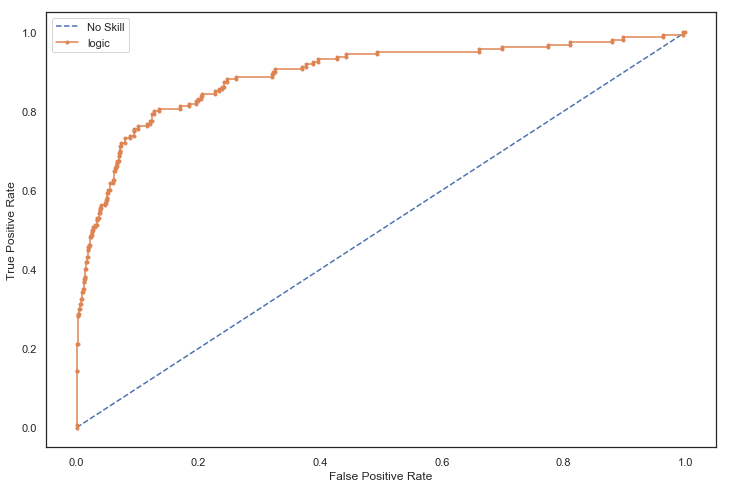

In [384]:

logic_probs=logic.predict_proba(X_test)
ns_probs = [0 for _ in range(len(y_test))]
ns_auc=roc_auc_score(y_test,ns_probs)
logic_probs=logic_probs[:,1]
logic_auc=roc_auc_score(y_test,logic_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('logic: ROC AUC=%.3f' % (logic_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
logic_fpr, logic_tpr, _ = roc_curve(y_test, logic_probs)


pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(logic_fpr, logic_tpr, marker='.', label='logic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


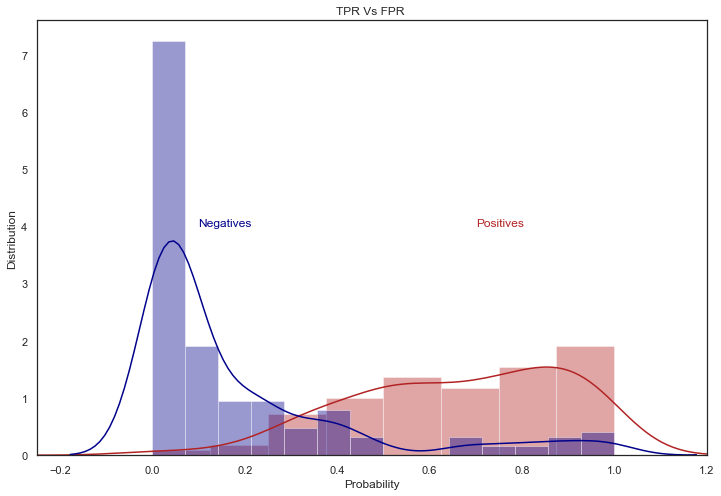

In [395]:
fig = plt.figure(figsize=(12,8))

sns.distplot(logic_tpr,color='firebrick')

sns.distplot(logic_fpr,color='darkblue')
plt.title('TPR Vs FPR ')
plt.xlim([-.25, 1.2])

plt.text(0.1,4,'Negatives',color='darkblue')
plt.text(0.7,4,'Positives',color='firebrick')
plt.xlabel('Probability')
plt.ylabel('Distribution')
plt.show()

In [386]:
log_train_pred_60=(logic.predict_proba(X_train)[:,1]>0.60).astype(bool)
log_val_pred_60=(logic.predict_proba(X_test)[:,1]>0.60).astype(bool)

In [391]:
cm0 = confusion_matrix(y_train, log_train_pred_60,labels=[1,0])
print('Confusion Matrix Train : \n', cm0)

cm1 = confusion_matrix(y_test, log_val_pred_60,labels=[1,0])
print('Confusion Matrix Test: \n', cm1)


KappaValue=cohen_kappa_score(y_test, log_val_pred_60)
print("Kappa Value :",KappaValue)
AUC=roc_auc_score(y_test, log_val_pred_60)

print("AUC         :",AUC)


Confusion Matrix Train : 
 [[ 305   41]
 [ 593 2848]]
Confusion Matrix Test: 
 [[ 129   31]
 [ 245 1218]]
Kappa Value : 0.4003389549157833
AUC         : 0.8193929425837321


In [392]:
##Random Forest
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=500,class_weight='balanced',random_state=101,max_depth=4)

rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=None, oob_score=False,
            random_state=101, verbose=0, warm_start=False)

No Skill: ROC AUC=0.500
rf: ROC AUC=0.929


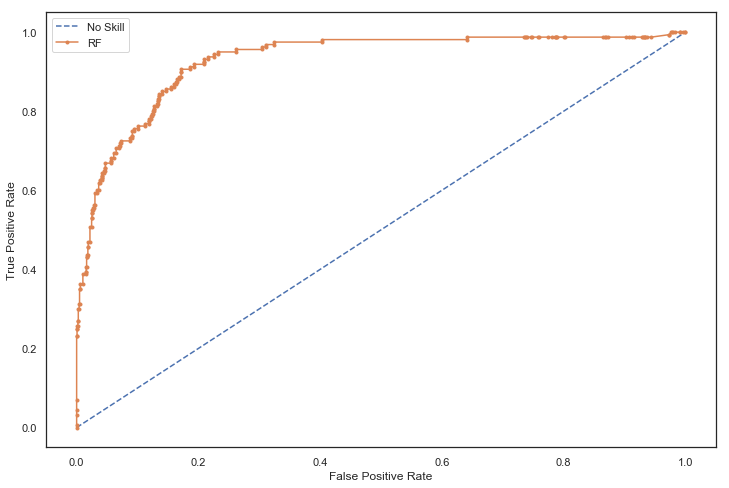

In [393]:
rf_probs=rf.predict_proba(X_test)
ns_probs = [0 for _ in range(len(y_test))]
ns_auc=roc_auc_score(y_test,ns_probs)
rf_probs=rf_probs[:,1]
rf_auc=roc_auc_score(y_test,rf_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('rf: ROC AUC=%.3f' % (rf_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)


pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(rf_fpr, rf_tpr, marker='.', label='RF')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

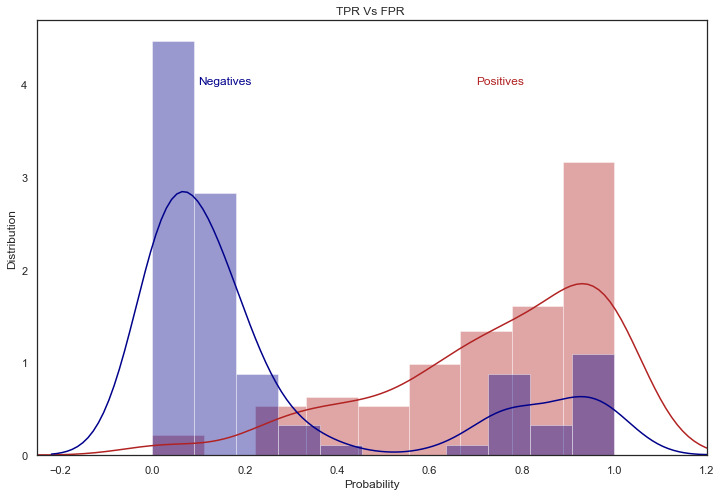

In [396]:
fig = plt.figure(figsize=(12,8))

sns.distplot(rf_tpr,color='firebrick')

sns.distplot(rf_fpr,color='darkblue')
plt.title('TPR Vs FPR ')
plt.xlim([-.25, 1.2])

plt.text(0.1,4,'Negatives',color='darkblue')
plt.text(0.7,4,'Positives',color='firebrick')
plt.xlabel('Probability')
plt.ylabel('Distribution')
plt.show()

In [398]:
rf_train_pred_50=(rf.predict_proba(X_train)[:,1]>0.50).astype(bool)
rf_val_pred_50=(rf.predict_proba(X_test)[:,1]>0.50).astype(bool)
cm0 = confusion_matrix(y_train, rf_train_pred_50,labels=[1,0])
print('Confusion Matrix Train : \n', cm0)

cm1 = confusion_matrix(y_test, rf_val_pred_50,labels=[1,0])
print('Confusion Matrix Test: \n', cm1)


KappaValue=cohen_kappa_score(y_test, rf_val_pred_50)
print("Kappa Value :",KappaValue)
AUC=roc_auc_score(y_test, rf_val_pred_50)

print("AUC         :",AUC)

Confusion Matrix Train : 
 [[ 306   40]
 [ 377 3064]]
Confusion Matrix Test: 
 [[ 131   29]
 [ 193 1270]]
Kappa Value : 0.4715774097604759
AUC         : 0.8434146445659604


In [406]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feat_labels=X.columns[1:]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))


 1) PerProviderAvg_DeductibleAmtPaid 0.090395
 2) DeductibleAmtPaid              0.082132
 3) PerOperatingPhysicianAvg_DeductibleAmtPaid 0.072536
 4) PerClmAdmitDiagnosisCodeAvg_DeductibleAmtPaid 0.052131
 5) PerOperatingPhysicianAvg_OPAnnualReimbursementAmt 0.048084
 6) PerClmAdmitDiagnosisCodeAvg_IPAnnualReimbursementAmt 0.041233
 7) PerProviderAvg_IPAnnualReimbursementAmt 0.040960
 8) AdmitForDays                   0.035465
 9) PerOperatingPhysicianAvg_IPAnnualDeductibleAmt 0.033714
10) PerClmDiagnosisCode_1Avg_IPAnnualReimbursementAmt 0.033114
11) NoOfMonths_PartACov            0.031535
12) PerClmAdmitDiagnosisCodeAvg_IPAnnualDeductibleAmt 0.030386
13) PerClmDiagnosisCode_4Avg_DeductibleAmtPaid 0.027352
14) PerClmDiagnosisCode_4Avg_IPAnnualReimbursementAmt 0.025695
15) PerClmProcedureCode_1Avg_DeductibleAmtPaid 0.019863
16) PerClmProcedureCode_1Avg_IPAnnualDeductibleAmt 0.019112
17) PerClmDiagnosisCode_1Avg_DeductibleAmtPaid 0.018997
18) PerClmProcedureCode_1Avg_OPAnnualReimburseme

IndexError: index 112 is out of bounds for axis 0 with size 112

In [380]:
##XGB
clf = xgb.XGBClassifier(n_jobs=12, n_estimators=500)
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric=["auc","error","logloss"],
        verbose=10)

[0]	validation_0-auc:0.93361	validation_0-error:0.04278	validation_0-logloss:0.47406	validation_1-auc:0.88657	validation_1-error:0.07887	validation_1-logloss:0.49166
[10]	validation_0-auc:0.98960	validation_0-error:0.02218	validation_0-logloss:0.08906	validation_1-auc:0.92759	validation_1-error:0.06901	validation_1-logloss:0.17857
[20]	validation_0-auc:0.99777	validation_0-error:0.01320	validation_0-logloss:0.06090	validation_1-auc:0.92666	validation_1-error:0.07086	validation_1-logloss:0.17831
[30]	validation_0-auc:0.99968	validation_0-error:0.00475	validation_0-logloss:0.04249	validation_1-auc:0.92701	validation_1-error:0.07394	validation_1-logloss:0.18459
[40]	validation_0-auc:0.99999	validation_0-error:0.00211	validation_0-logloss:0.03079	validation_1-auc:0.92337	validation_1-error:0.07271	validation_1-logloss:0.19407
[50]	validation_0-auc:1.00000	validation_0-error:0.00026	validation_0-logloss:0.02243	validation_1-auc:0.92168	validation_1-error:0.07579	validation_1-logloss:0.20267

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=500, n_jobs=12, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

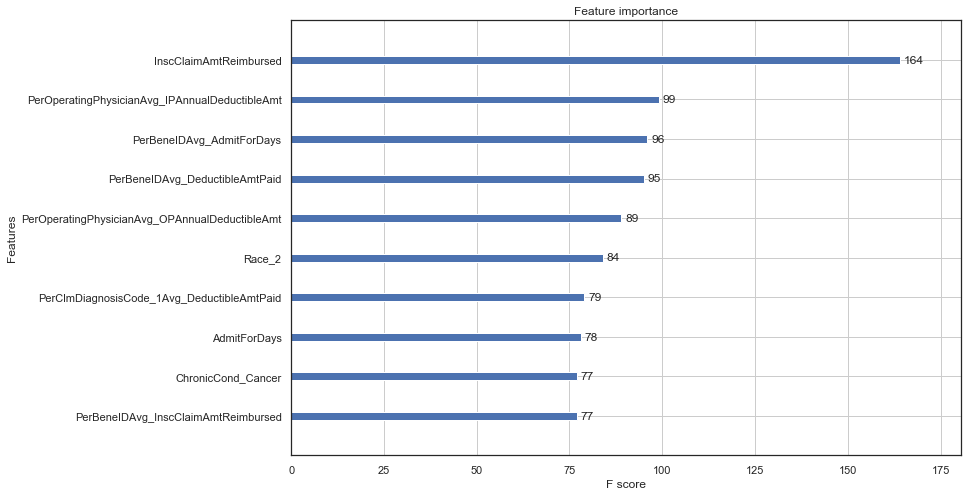

In [383]:
plot_importance(clf,max_num_features=10)

No Skill: ROC AUC=0.500
XGB: ROC AUC=0.904


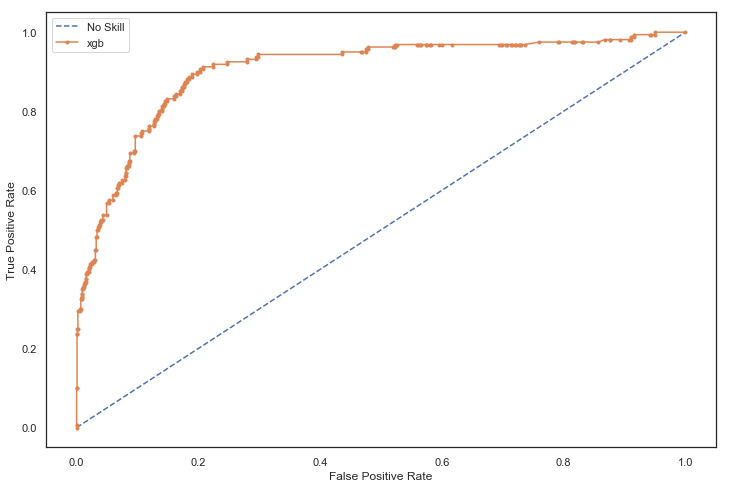

In [382]:
xgb_probs=clf.predict_proba(X_test)
ns_probs = [0 for _ in range(len(y_test))]
ns_auc=roc_auc_score(y_test,ns_probs)
xgb_probs=xgb_probs[:,1]
xgb_auc=roc_auc_score(y_test,xgb_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGB: ROC AUC=%.3f' % (xgb_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(xgb_fpr, xgb_tpr, marker='.', label='xgb')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

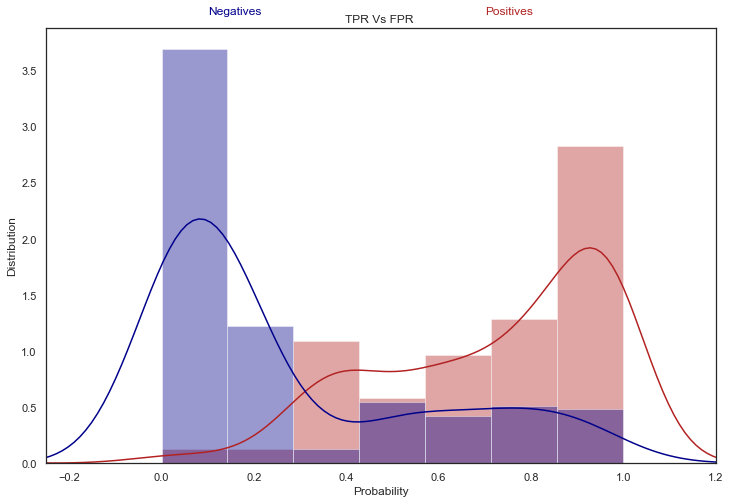

In [399]:
fig = plt.figure(figsize=(12,8))

sns.distplot(xgb_tpr,color='firebrick')

sns.distplot(xgb_fpr,color='darkblue')
plt.title('TPR Vs FPR ')
plt.xlim([-.25, 1.2])

plt.text(0.1,4,'Negatives',color='darkblue')
plt.text(0.7,4,'Positives',color='firebrick')
plt.xlabel('Probability')
plt.ylabel('Distribution')
plt.show()

In [401]:
xgb_train_pred_50=(clf.predict_proba(X_train)[:,1]>0.50).astype(bool)
xgb_val_pred_50=(clf.predict_proba(X_test)[:,1]>0.50).astype(bool)
cm0 = confusion_matrix(y_train, xgb_train_pred_50,labels=[1,0])
print('Confusion Matrix Train : \n', cm0)

cm1 = confusion_matrix(y_test, xgb_val_pred_50,labels=[1,0])
print('Confusion Matrix Test: \n', cm1)


KappaValue=cohen_kappa_score(y_test, xgb_val_pred_50)
print("Kappa Value :",KappaValue)
AUC=roc_auc_score(y_test, xgb_val_pred_50)

print("AUC         :",AUC)

Confusion Matrix Train : 
 [[ 346    0]
 [   0 3441]]
Confusion Matrix Test: 
 [[  66   94]
 [  35 1428]]
Kappa Value : 0.4649218085119977
AUC         : 0.6942882775119618
